<a href="https://colab.research.google.com/github/brdeleon/flagging_loans_shapley_values/blob/main/flagging_loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flagging Loans

## Imports

In [275]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [276]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [277]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [278]:
import warnings
warnings.filterwarnings("ignore")

import joblib as jb
from joblib import dump, load

import os
import shap
import math
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import kaleido
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, brier_score_loss, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as ltb
from lightgbm import LGBMClassifier
import catboost as ctb
from catboost import CatBoostClassifier

seed = np.random.seed(42)

## Exploratory Data Analysis

In [279]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [280]:
df = pd.read_csv('/content/drive/MyDrive/loan_data/loan_dataset.csv', parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'])

In [281]:
# previewing first 5 rows and last 5 rows of the dataset
df.head().append(df.tail())

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaT,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaT,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaT,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaT,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0
4152,533637,2016-06-11,2016-05-17,NaN,NaN,NaN,NaT,0.0,region_5,7,...,1,0,0,0,NaN,NaN,563.089780,26.0,False,0
4153,596156,2016-08-06,2016-03-11,NaN,NaN,NaN,NaT,1.0,region_2,12,...,4,0,0,0,3.0,NaN,576.875277,38.0,False,1
4154,645359,2016-09-05,2016-04-30,NaN,NaN,NaN,NaT,1.0,region_2,12,...,4,0,0,0,4.0,NaN,554.816921,21.0,False,0
4155,730681,2016-10-14,2016-05-20,NaN,NaN,NaN,NaT,0.0,region_6,7,...,4,0,0,0,4.0,NaN,563.089780,35.0,False,0
4156,521420,2016-06-02,2015-12-08,2.0,2.0,0.0,2016-02-13,0.0,region_4,12,...,6,0,0,0,5.0,NaN,NaN,25.0,False,1


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              4157 non-null   int64         
 1   rep_loan_date        4157 non-null   datetime64[ns]
 2   first_loan           4157 non-null   datetime64[ns]
 3   dpd_5_cnt            675 non-null    float64       
 4   dpd_15_cnt           675 non-null    float64       
 5   dpd_30_cnt           675 non-null    float64       
 6   first_overdue_date   675 non-null    datetime64[ns]
 7   close_loans_cnt      4142 non-null   float64       
 8   federal_district_nm  4146 non-null   object        
 9   TraderKey            4157 non-null   int64         
 10  payment_type_0       4157 non-null   int64         
 11  payment_type_1       4157 non-null   int64         
 12  payment_type_2       4157 non-null   int64         
 13  payment_type_3       4157 non-nul

### Null Values

In [283]:
# df.isnull().sum()
# Check the initial null value counts
initial_null_counts = df.isnull().sum()
print("Initial Null Value Counts:\n", initial_null_counts)

Initial Null Value Counts:
 loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64


In [284]:
# calculating nulls
nulls = df.isnull().sum()

In [285]:
# calculating null percentage of columns with nulls
null_percent = nulls[nulls>0] / len(df)
null_percent.sort_values(ascending=False).to_frame('% Null').style

,% Null
score_2,0.942507
dpd_5_cnt,0.837623
dpd_15_cnt,0.837623
dpd_30_cnt,0.837623
first_overdue_date,0.837623
score_1,0.156363
past_billings_cnt,0.059658
close_loans_cnt,0.003608
federal_district_nm,0.002646


In [286]:
# extracting columns with excesssive nulls set at 10%
null_columns = null_percent[null_percent>.90].index.tolist()
null_columns

['score_2']

In [287]:
df['score_2'].value_counts(dropna=False)

NaN           3918
563.089780      31
572.357000      25
518.895382      25
576.875277      15
546.439438      14
554.816921      11
564.084141      11
556.757944       8
529.213889       8
535.545724       8
561.276222       7
538.166579       5
550.957715       5
539.335885       5
548.485086       4
533.918380       4
603.311653       4
559.335199       4
583.194320       4
567.608057       3
544.812944       3
598.793375       2
568.602419       2
570.630791       2
553.003363       2
523.736829       2
513.513456       2
572.875813       2
532.104821       2
527.586544       2
577.394091       1
485.874267       1
505.145464       1
506.374324       1
553.980449       1
531.063026       1
513.418322       1
575.149069       1
517.268037       1
589.526155       1
515.463970       1
556.505040       1
521.786315       1
542.684857       1
515.641544       1
538.436657       1
549.331222       1
Name: score_2, dtype: int64

In [288]:
# dropping column list and checking shape
df = df.drop(columns = null_columns)
print(df.shape)

(4157, 21)


There are 4 remaining columns with high null values, they all seem to address similar data. We will drop the first_overdue_date data as it is represented in some capacity with dpd_5_cnt. [as the object column likely represents a date or timestamp indicating the first occurrence of delinquency, which is a different type of information compared to the count of delinquency days. Therefore, it is unlikely that there would be direct multicollinearity between the float64 columns and the object column.]
However, it's important to note that multicollinearity can also arise indirectly in a model when multiple correlated predictors are used together, even if they are of different data types. For example, if the date or timestamp information in the object column is used to derive additional features that are highly correlated with the float64 columns, multicollinearity may still be an issue. Therefore, it is important to carefully analyze the data, conduct exploratory data analysis (EDA), and assess for multicollinearity using appropriate techniques, as mentioned in the previous response, to determine if multicollinearity is indeed present and take appropriate steps to address it if needed.

In [289]:
 df['first_overdue_date'].value_counts(dropna=False)

NaT           3482
2016-01-15      63
2016-04-30      25
2016-05-30      21
2016-01-30      20
              ... 
2016-11-13       1
2016-05-19       1
2016-08-30       1
2015-06-10       1
2016-07-18       1
Name: first_overdue_date, Length: 79, dtype: int64

In [290]:
df['dpd_5_cnt'].value_counts(dropna=False)

NaN    3482
1.0     484
2.0     114
3.0      47
4.0      14
5.0       7
0.0       4
6.0       4
7.0       1
Name: dpd_5_cnt, dtype: int64

In [291]:
df[['dpd_5_cnt', 'first_overdue_date']].head(20)

,dpd_5_cnt,first_overdue_date
0,NaN,NaT
1,1.0,2016-01-30
2,NaN,NaT
3,NaN,NaT
4,NaN,NaT
5,NaN,NaT
6,1.0,2015-11-06
7,1.0,2015-11-06
8,3.0,2016-01-15
9,1.0,2015-11-06


In [292]:
 df['dpd_15_cnt'].value_counts(dropna=False)

NaN    3482
1.0     314
0.0     281
2.0      66
3.0       9
4.0       3
5.0       2
Name: dpd_15_cnt, dtype: int64

In [293]:
 df['dpd_30_cnt'].value_counts(dropna=False)

NaN    3482
0.0     502
1.0     158
2.0      14
3.0       1
Name: dpd_30_cnt, dtype: int64

In [294]:
# Fill nulls with 0 for specific columns
columns_to_fill_with_zero = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'first_overdue_date']
df[columns_to_fill_with_zero] = df[columns_to_fill_with_zero].fillna(0)

In [295]:
# Checking for nulls after data edits
df.isnull().sum()

loanKey                  0
rep_loan_date            0
first_loan               0
dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
first_overdue_date       0
close_loans_cnt         15
federal_district_nm     11
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt      248
score_1                650
age                      0
gender                   0
bad_flag                 0
dtype: int64

In [296]:
corr_matrix = df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].corr()
print(corr_matrix)


            dpd_5_cnt  dpd_15_cnt  dpd_30_cnt
dpd_5_cnt    1.000000    0.745065    0.462980
dpd_15_cnt   0.745065    1.000000    0.642321
dpd_30_cnt   0.462980    0.642321    1.000000


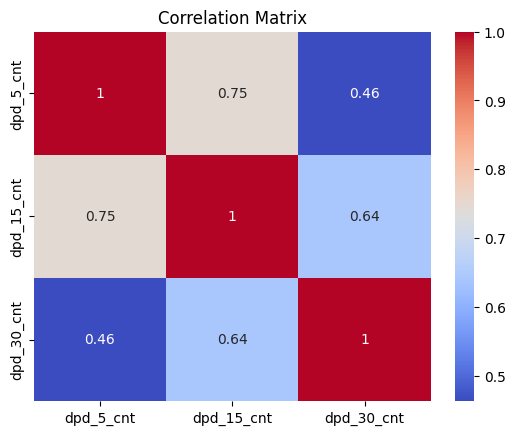

In [297]:
corr_matrix = df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show();

In [298]:
df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].head(35)

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,1.0,0.0
8,3.0,1.0,0.0
9,1.0,1.0,0.0


In [299]:
df['dpd_5_cnt'].value_counts(dropna=False)

0.0    3486
1.0     484
2.0     114
3.0      47
4.0      14
5.0       7
6.0       4
7.0       1
Name: dpd_5_cnt, dtype: int64

In [300]:
df['dpd_15_cnt'].value_counts(dropna=False)

0.0    3763
1.0     314
2.0      66
3.0       9
4.0       3
5.0       2
Name: dpd_15_cnt, dtype: int64

In [301]:
df['dpd_30_cnt'].value_counts(dropna=False)

0.0    3984
1.0     158
2.0      14
3.0       1
Name: dpd_30_cnt, dtype: int64

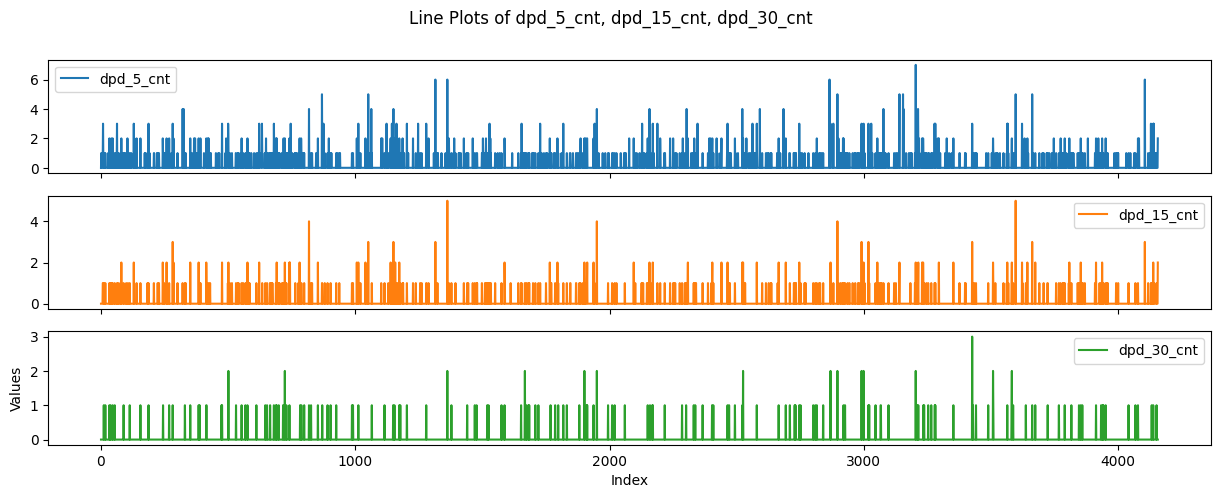

In [302]:
import matplotlib.pyplot as plt

# Extract columns from the DataFrame
columns = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']
df[columns].plot(subplots=True, layout=(len(columns),1), figsize=(15,5))

# Set the title and labels for the plot
plt.suptitle('Line Plots of dpd_5_cnt, dpd_15_cnt, dpd_30_cnt')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()


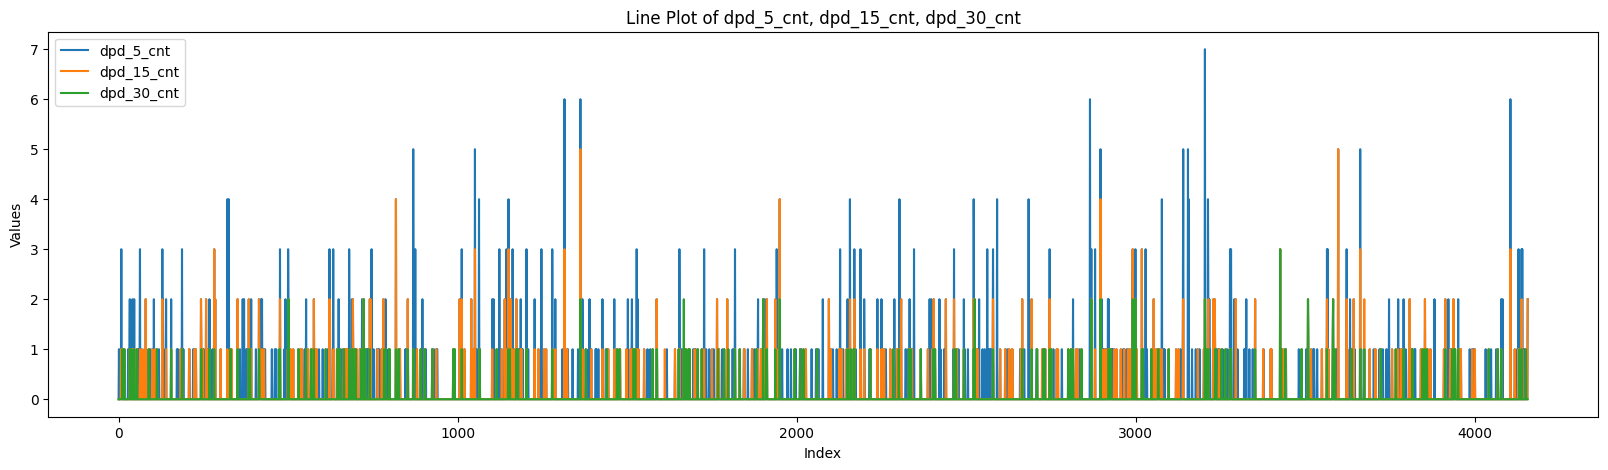

In [303]:
# Extract columns from the DataFrame
columns = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']
df[columns].plot(legend=True, figsize=(20,5))

# Set the title and labels for the plot
plt.title('Line Plot of dpd_5_cnt, dpd_15_cnt, dpd_30_cnt')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()


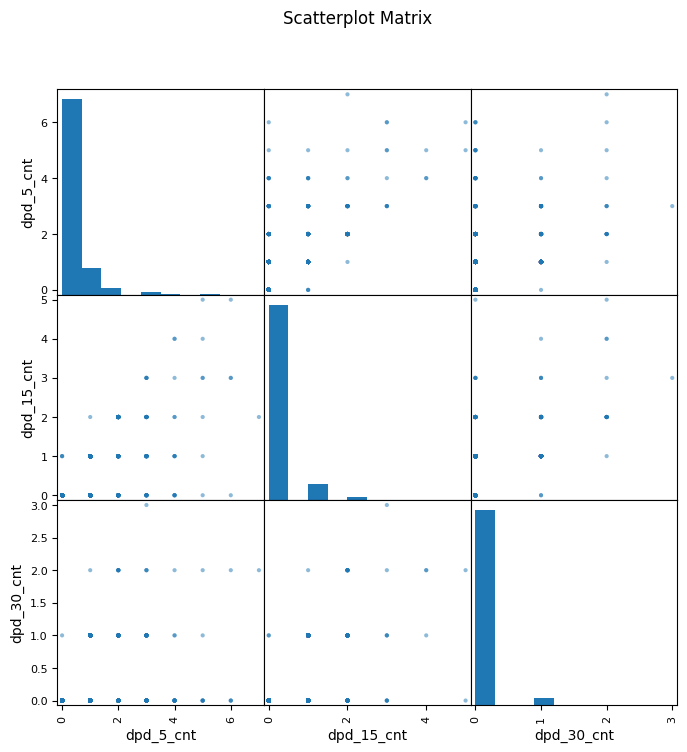

In [304]:
import pandas.plotting as pdplt

pdplt.scatter_matrix(df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']], figsize=(8, 8), diagonal='hist')
plt.suptitle('Scatterplot Matrix')
plt.show()


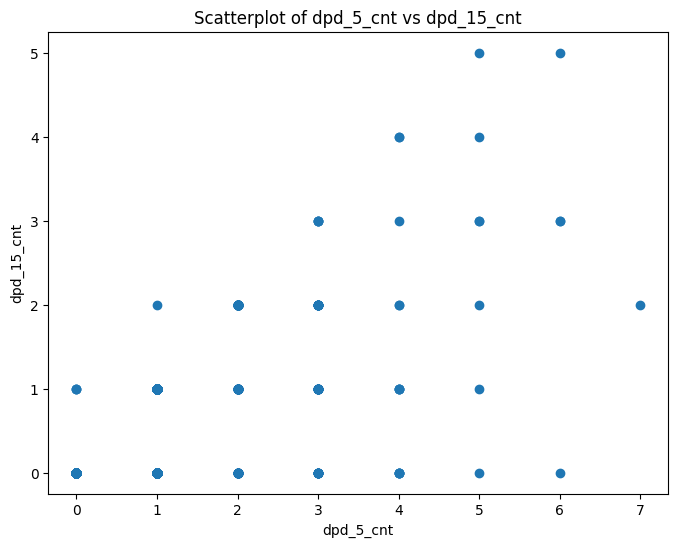

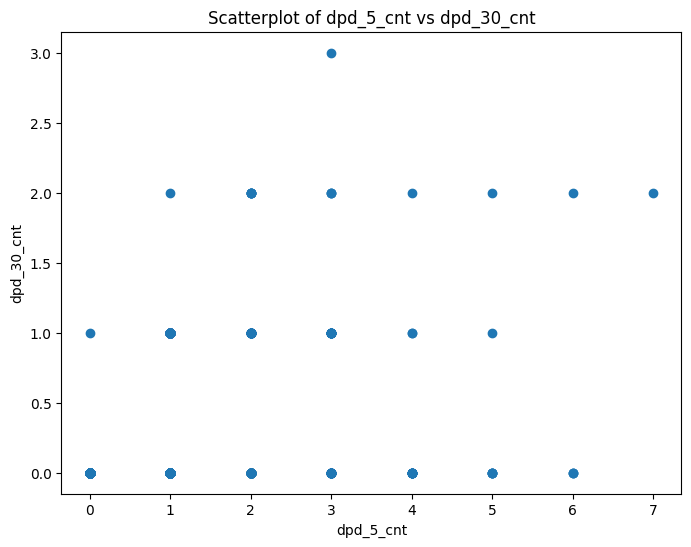

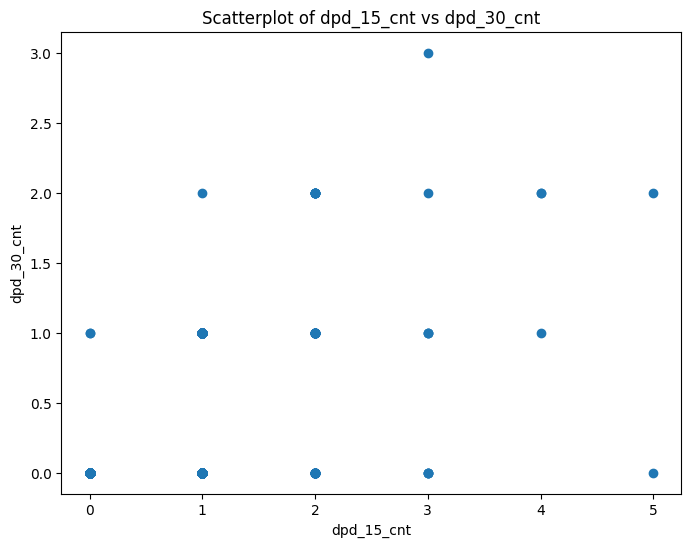

In [305]:
plt.figure(figsize=(8, 6))
plt.scatter(df['dpd_5_cnt'], df['dpd_15_cnt'])
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_15_cnt')
plt.title('Scatterplot of dpd_5_cnt vs dpd_15_cnt')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['dpd_5_cnt'], df['dpd_30_cnt'])
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_30_cnt')
plt.title('Scatterplot of dpd_5_cnt vs dpd_30_cnt')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['dpd_15_cnt'], df['dpd_30_cnt'])
plt.xlabel('dpd_15_cnt')
plt.ylabel('dpd_30_cnt')
plt.title('Scatterplot of dpd_15_cnt vs dpd_30_cnt')
plt.show();

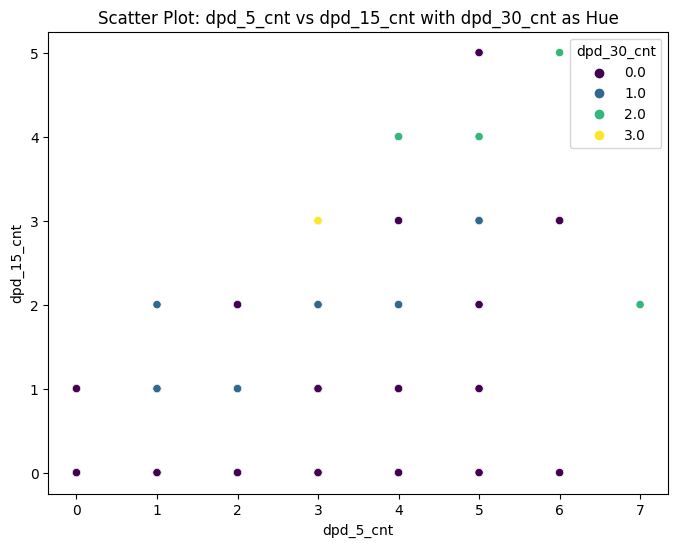

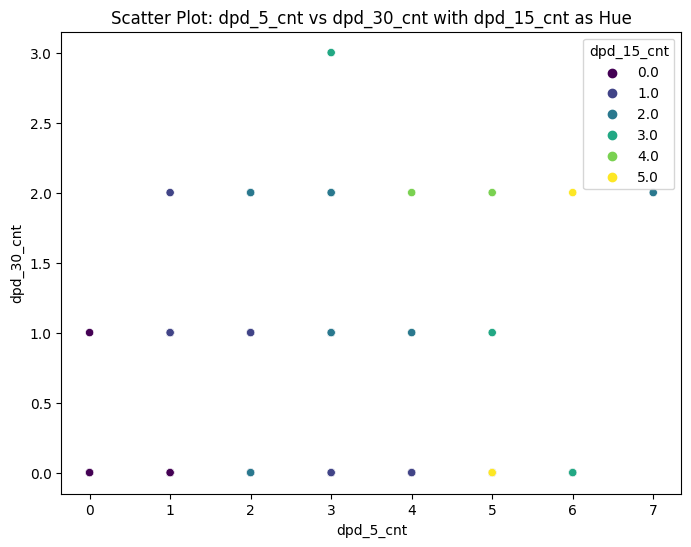

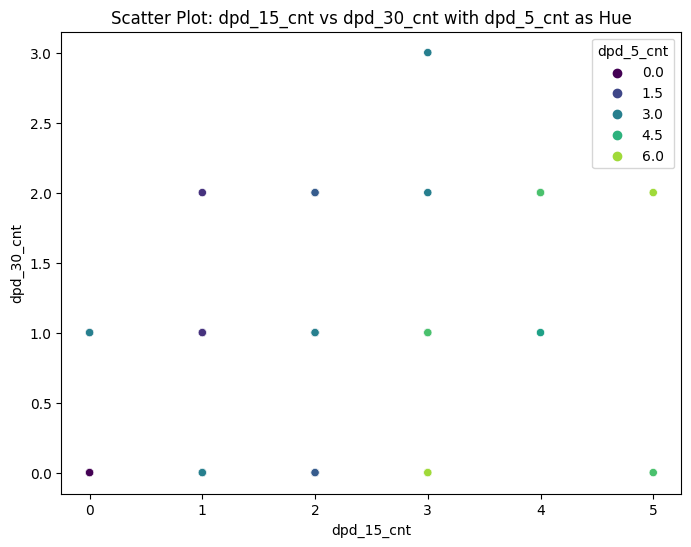

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plots
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='dpd_5_cnt', y='dpd_15_cnt', hue='dpd_30_cnt', palette='viridis')
plt.title('Scatter Plot: dpd_5_cnt vs dpd_15_cnt with dpd_30_cnt as Hue')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_15_cnt')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='dpd_5_cnt', y='dpd_30_cnt', hue='dpd_15_cnt', palette='viridis')
plt.title('Scatter Plot: dpd_5_cnt vs dpd_30_cnt with dpd_15_cnt as Hue')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='dpd_15_cnt', y='dpd_30_cnt', hue='dpd_5_cnt', palette='viridis')
plt.title('Scatter Plot: dpd_15_cnt vs dpd_30_cnt with dpd_5_cnt as Hue')
plt.xlabel('dpd_15_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()


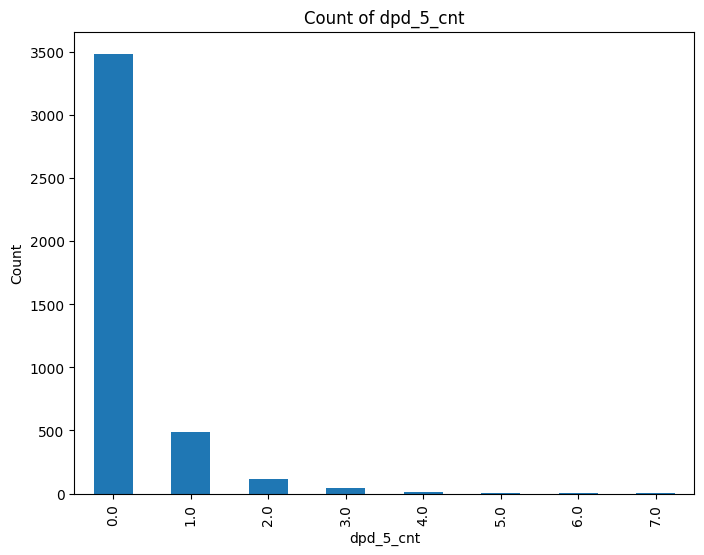

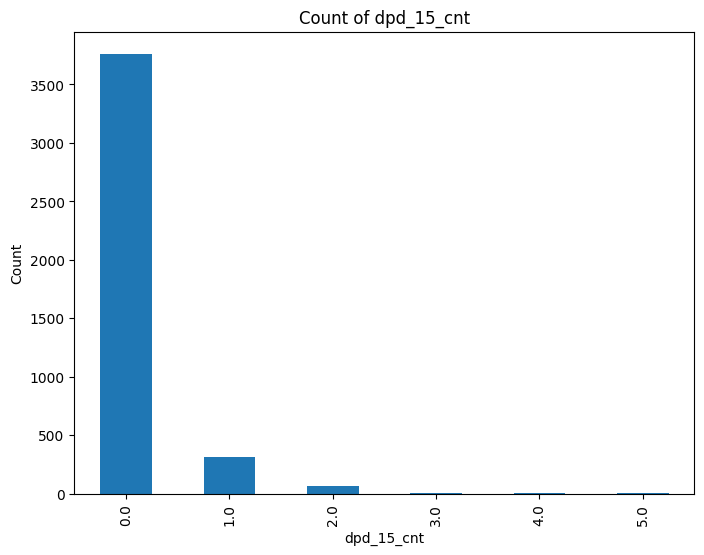

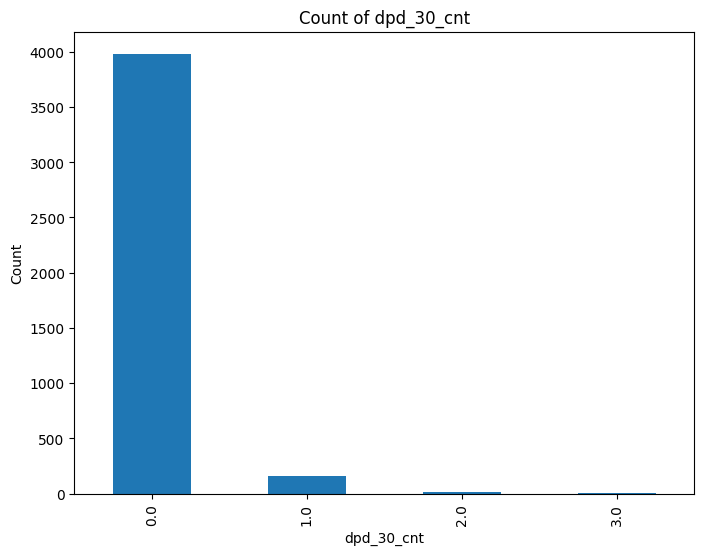

In [307]:
# Bar chart for dpd_5_cnt
plt.figure(figsize=(8, 6))
df['dpd_5_cnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of dpd_5_cnt')
plt.xlabel('dpd_5_cnt')
plt.ylabel('Count')
plt.show()

# Bar chart for dpd_15_cnt
plt.figure(figsize=(8, 6))
df['dpd_15_cnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of dpd_15_cnt')
plt.xlabel('dpd_15_cnt')
plt.ylabel('Count')
plt.show()

# Bar chart for dpd_30_cnt
plt.figure(figsize=(8, 6))
df['dpd_30_cnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of dpd_30_cnt')
plt.xlabel('dpd_30_cnt')
plt.ylabel('Count')
plt.show()


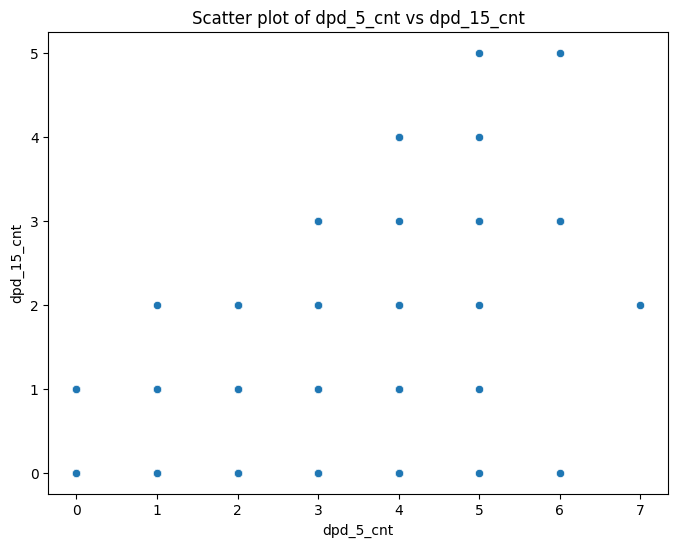

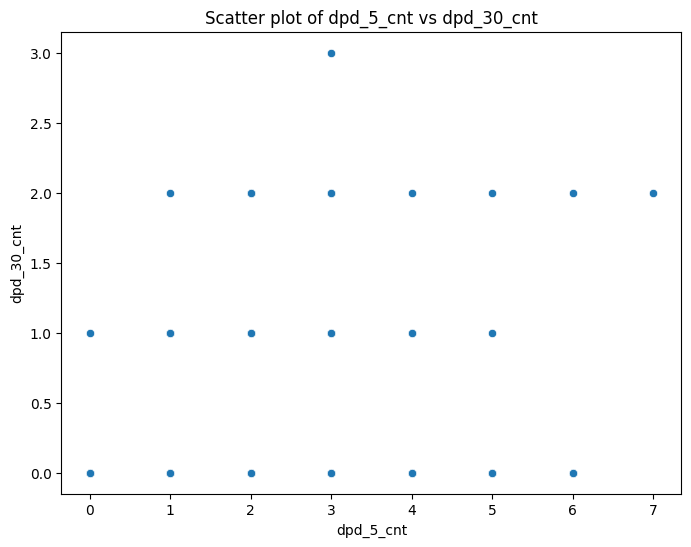

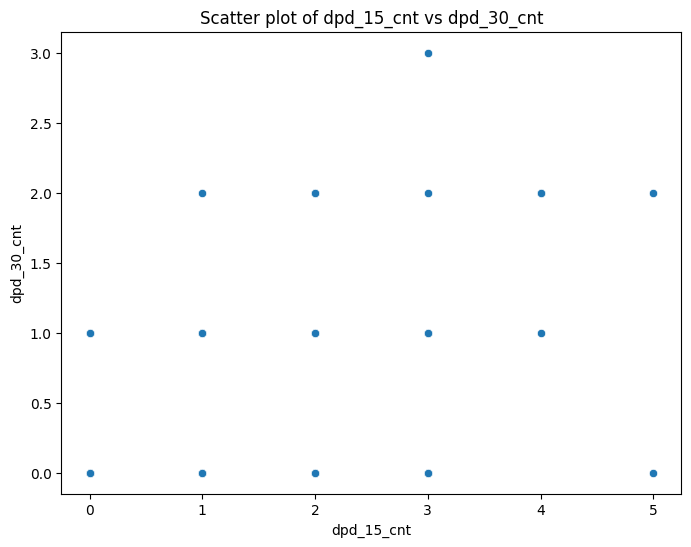

In [308]:
# Scatter plot for dpd_5_cnt vs dpd_15_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dpd_5_cnt', y='dpd_15_cnt', data=df)
plt.title('Scatter plot of dpd_5_cnt vs dpd_15_cnt')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_15_cnt')
plt.show()

# Scatter plot for dpd_5_cnt vs dpd_30_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dpd_5_cnt', y='dpd_30_cnt', data=df)
plt.title('Scatter plot of dpd_5_cnt vs dpd_30_cnt')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()

# Scatter plot for dpd_15_cnt vs dpd_30_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dpd_15_cnt', y='dpd_30_cnt', data=df)
plt.title('Scatter plot of dpd_15_cnt vs dpd_30_cnt')
plt.xlabel('dpd_15_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()


We will perform PCA on the three columns to preserve the important information while avoiding the multicolinearity that was present.

In [309]:
df.isnull().sum()

loanKey                  0
rep_loan_date            0
first_loan               0
dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
first_overdue_date       0
close_loans_cnt         15
federal_district_nm     11
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt      248
score_1                650
age                      0
gender                   0
bad_flag                 0
dtype: int64

In [310]:
# Drop rows with nulls in 'close_loans_cnt', 'federal_district_nm' columns in one line
df.dropna(subset=['close_loans_cnt', 'federal_district_nm'], inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

In [311]:
df['past_billings_cnt'].value_counts(dropna=False)

3.0     806
6.0     521
1.0     496
2.0     489
5.0     335
4.0     287
NaN     233
7.0     205
8.0     176
9.0     152
10.0    122
11.0     72
12.0     69
13.0     43
14.0     40
16.0     28
15.0     22
17.0     19
18.0      9
19.0      3
20.0      2
21.0      2
Name: past_billings_cnt, dtype: int64

We will fill the null values with zeros to represent that these rows are missing a value because they do not have any past bills. The assumption is that this is their first loan.

In [312]:
df['past_billings_cnt'] = df['past_billings_cnt'].fillna(0)
df.isnull().sum()

loanKey                  0
rep_loan_date            0
first_loan               0
dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
first_overdue_date       0
close_loans_cnt          0
federal_district_nm      0
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt        0
score_1                645
age                      0
gender                   0
bad_flag                 0
dtype: int64

df['score_1']

In [313]:
# Find the lowest value in the 'score_1' column
lowest_value = df['score_1'].min()

# Display the lowest value
print(lowest_value)

384.22062775079314


In [314]:

# Sort the 'score_1' column in ascending order, including any 0 and null values
sorted_df = df.sort_values('score_1', ascending=True, na_position='first')

# Select the first 647 rows from the sorted DataFrame
lowest_values = sorted_df['score_1'].head(647)

# Display the lowest values
print(lowest_values)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
4128           NaN
4129           NaN
4130           NaN
978     384.220628
1257    385.181110
Name: score_1, Length: 647, dtype: float64


In [315]:
sorted_df[['score_1','first_loan','past_billings_cnt','age']].head(647)

,score_1,first_loan,past_billings_cnt,age
0,NaN,2015-11-13,10.0,21.0
1,NaN,2015-09-28,5.0,20.0
2,NaN,2015-12-21,5.0,19.0
3,NaN,2015-06-30,6.0,21.0
4,NaN,2015-08-03,3.0,33.0
...,...,...,...,...
4128,NaN,2016-04-30,4.0,21.0
4129,NaN,2016-05-20,4.0,35.0
4130,NaN,2015-12-08,5.0,25.0
978,384.220628,2015-08-30,0.0,21.0


In [316]:
sorted_df['age'].value_counts()

28.0    189
27.0    177
31.0    176
30.0    167
26.0    164
32.0    161
24.0    158
29.0    154
33.0    151
35.0    145
25.0    141
34.0    139
23.0    131
36.0    125
21.0    121
39.0    111
37.0    109
38.0    102
22.0    101
41.0    101
40.0     98
20.0     89
18.0     81
43.0     79
42.0     77
44.0     66
19.0     65
46.0     59
47.0     59
45.0     57
51.0     53
48.0     52
54.0     45
53.0     43
49.0     40
56.0     39
52.0     38
55.0     36
59.0     34
58.0     33
57.0     32
50.0     32
63.0     22
60.0     22
61.0     18
62.0     16
64.0     14
65.0      6
67.0      1
70.0      1
74.0      1
Name: age, dtype: int64

We will assume that the null values are representative of having no credit score.

In [317]:
# Fill missing values in 'score_1' column with 0
df['score_1'] = df['score_1'].fillna(0)

In [318]:
# Check the final null value counts 
final_null_counts = df.isnull().sum()
print(f"Final Null Value Counts:\n{final_null_counts}")

Final Null Value Counts:
loanKey                0
rep_loan_date          0
first_loan             0
dpd_5_cnt              0
dpd_15_cnt             0
dpd_30_cnt             0
first_overdue_date     0
close_loans_cnt        0
federal_district_nm    0
TraderKey              0
payment_type_0         0
payment_type_1         0
payment_type_2         0
payment_type_3         0
payment_type_4         0
payment_type_5         0
past_billings_cnt      0
score_1                0
age                    0
gender                 0
bad_flag               0
dtype: int64


### Duplicates
We will check for duplicates and remove them. We will check the dataset shape to confirm their removal.

In [319]:
# Checking for duplicates and df shape 
print(df.duplicated().sum())
df.shape

0


(4131, 21)

In [320]:
# Saving final df as a new csv file
df.to_csv('/content/drive/MyDrive/loan_data/clean_loan_df.csv',index=False)

### Correlation Check

Checking for multicolinearity amongst the features in the data.

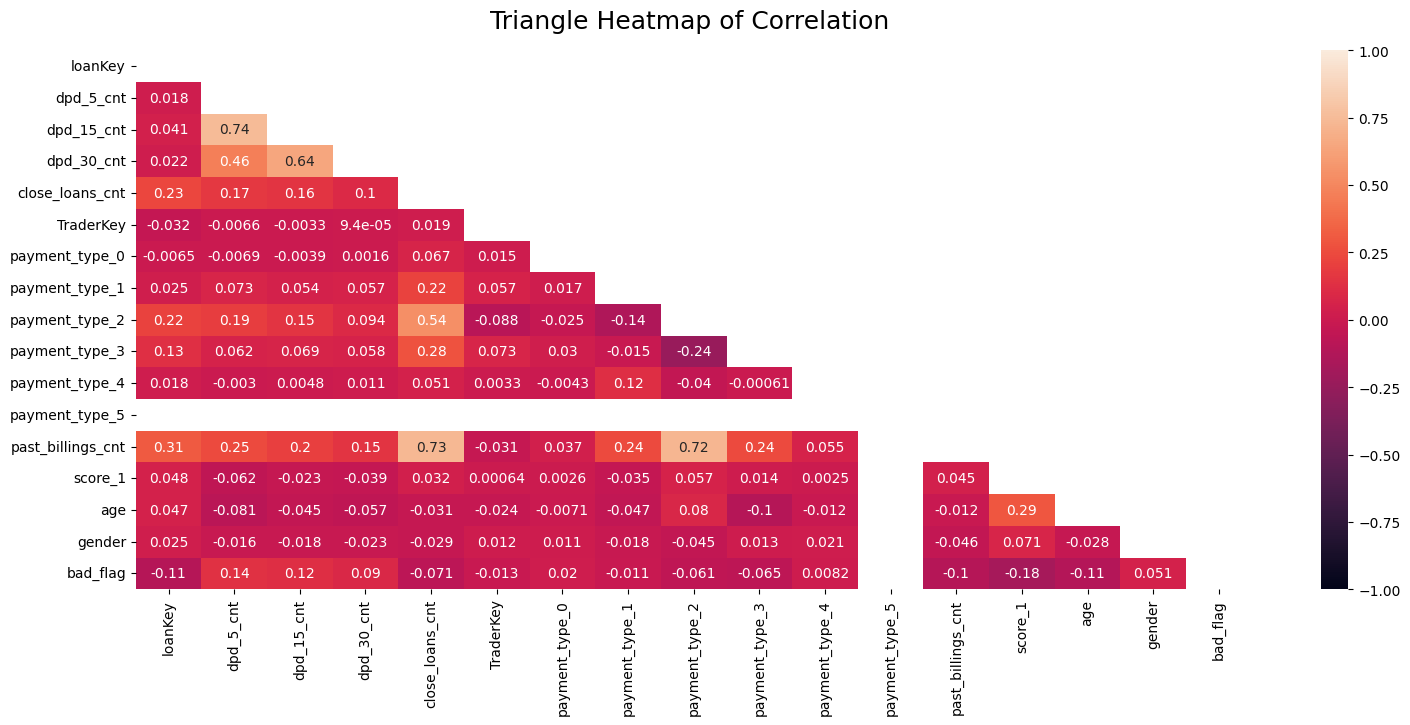

In [321]:
# setting figure size
plt.figure(figsize=(18,7))
# creating heatmap 
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, annot=True, vmin=-1, vmax=1, linecolor='black')
heatmap.set_title('Triangle Heatmap of Correlation ', fontdict={'fontsize':18}, pad=16);

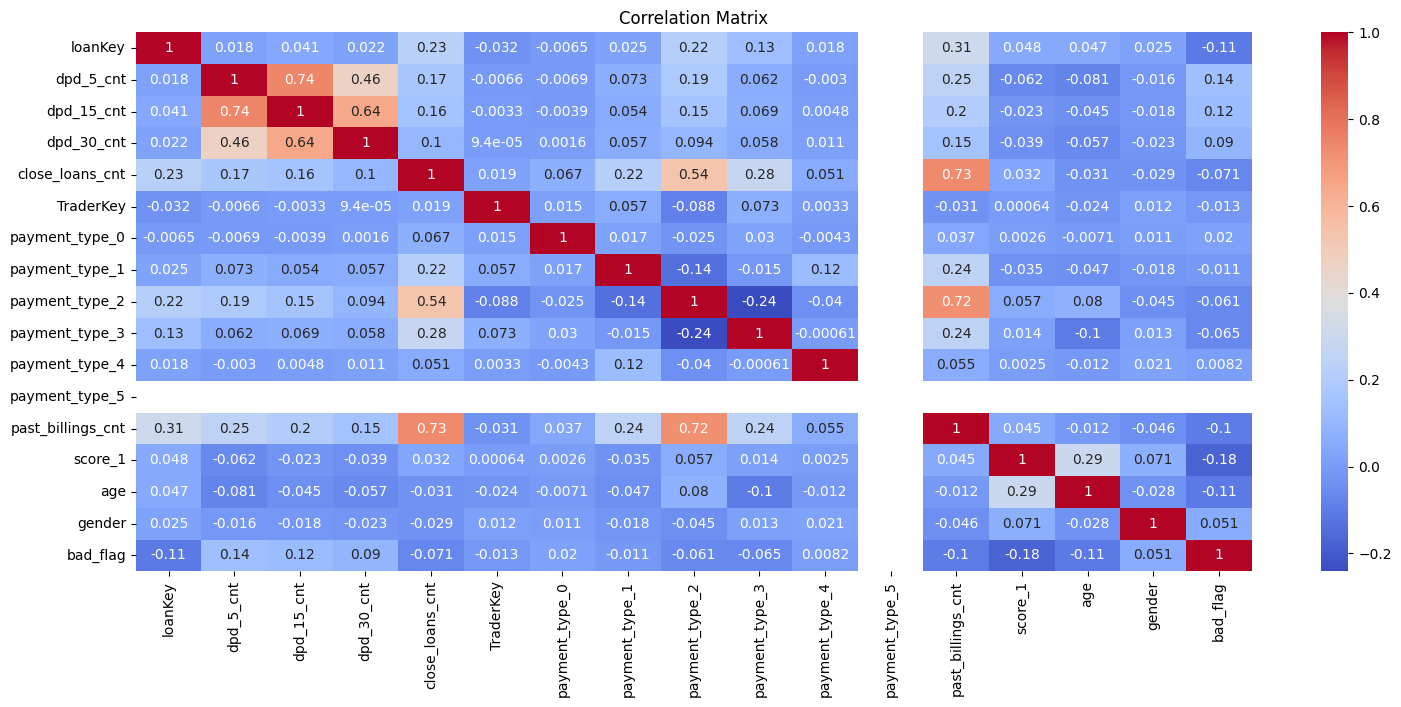

In [322]:
# setting figure size
plt.figure(figsize=(18,7))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show();

There are a couple of features showing some levels of multicolinearity. We will look at each feature indvidually to see how to best handle each. We will then revisit the heatmap.

### Target
We will explore the target which labels each entry as flagged or non-flagged.

In [323]:
# Checking proportions of target
df['bad_flag'].value_counts(normalize=True)

0    0.900266
1    0.099734
Name: bad_flag, dtype: float64

In [324]:
# Creating seperate dataframes for flagged and non flagged transactions
data_flagged = df[df['bad_flag'] == 1]
# Non flagged dataframe
data_non_flagged = df[df['bad_flag'] == 0]

In [325]:
# Showing there is high imbalance in our target
print("Flagged Entries: " + str(len(data_flagged)))
print("Non-Flagged Entries: " + str(len(data_non_flagged)))
print("Proportion of Flagged Cases: " + str(len(data_flagged)/ df.shape[0]))

Flagged Entries: 412
Non-Flagged Entries: 3719
Proportion of Flagged Cases: 0.09973372064875333


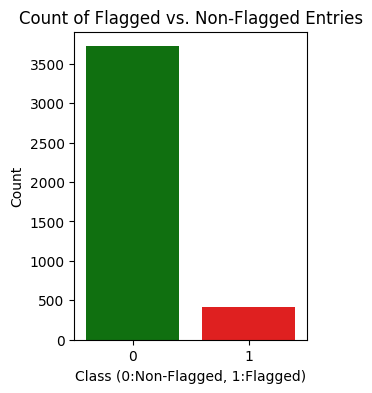

In [326]:
# Visually comparing number of flagged and non-flagged transactions 
counts = df.bad_flag.value_counts()
# use green for bar with max value and red for minority
color = ['red' if (x < max(counts)) else 'green' for x in counts]
# setting figure size
plt.figure(figsize=(3,4))
# create barplot using specified colors
sns.barplot(x=counts.index, y=counts, palette=color)
plt.title('Count of Flagged vs. Non-Flagged Entries')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Flagged, 1:Flagged)');

In [327]:
import plotly.graph_objects as go

# Compute value counts for 'bad_flag' column
counts = df['bad_flag'].value_counts()

# Calculate percentage
total_count = counts.sum()
percentage = counts / total_count * 100

# Define colors for the bars
color = ['red' if (x < max(counts)) else 'green' for x in counts]

# Create a hover template with count and percentage
hover_template = 'Count: %{y}<br>Percentage: %{customdata:.2f}%'

# Create a bar trace with specified colors and hover template
trace = go.Bar(x=counts.index, y=counts.values, 
               marker=dict(color=color),
               hovertemplate=hover_template,
               customdata=percentage)

# Create a layout for the chart
layout = go.Layout(title='Count of Flagged vs. Non-Flagged Entries',
                   xaxis=dict(title='Class (0:Non-Flagged, 1:Flagged)',
                              ticktext=['Non-Flagged', 'Flagged'],  # custom tick labels
                              tickvals=[0, 1]),  # custom tick values
                   yaxis=dict(title='Count'),
                   width=500,  # custom width in pixels
                   height=500) # custom height in pixels

# Create a Figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show();

In [328]:
import plotly.graph_objects as go

# Compute value counts for 'bad_flag' column
counts = df['bad_flag'].value_counts()

# Calculate percentage
total_count = counts.sum()
percentage = counts / total_count * 100

# Define colors for the bars
color = ['red' if (x < max(counts)) else 'green' for x in counts]

# Create a custom hover function to create hover labels
def create_hover_labels(counts, percentage):
    hover_labels = []
    for count, perc in zip(counts, percentage):
        hover_label = f'Count: {count}<br>Percentage: {perc:.2f}%'
        hover_labels.append(hover_label)
    return hover_labels

# Call the custom hover function to create hover labels
hover_labels = create_hover_labels(counts.values, percentage.values)

# Create a bar trace with specified colors and hover labels
trace = go.Bar(x=counts.index, y=counts.values, 
               marker=dict(color=color),
               hovertext=hover_labels)  # use custom hover labels

# Create a layout for the chart
layout = go.Layout(title='Count of Flagged vs. Non-Flagged Entries',
                   xaxis=dict(title='Class (0:Non-Flagged, 1:Flagged)',
                              ticktext=['Non-Flagged', 'Flagged'],  # custom tick labels
                              tickvals=[0, 1]),  # custom tick values
                   yaxis=dict(title='Count'),
                   width=500,  # custom width in pixels
                   height=500) # custom height in pixels

# Create a Figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show();

**Notes:** We are dealing with a target that is heavily imbalanced with only 0.0017% of the transactions designated as fraud.

**Next:** We will exlore the remaining features, first focusing on the feature: 'loanKey'


### Loan Key
Defined as: the Application ID


In [329]:
# inspecting values
df.loanKey.value_counts(dropna=False)

708382    1
631741    1
193087    1
540328    1
669814    1
         ..
487229    1
438381    1
320315    1
434896    1
521420    1
Name: loanKey, Length: 4131, dtype: int64

In [330]:
# calculates the number of unique values to compare with total values
print(len(df.loanKey.unique()))
len(df.loanKey)

4131


4131

### Loan Date
Represented as: 'rep_loan_date'

In [331]:
# inspecting values
df.rep_loan_date.value_counts(dropna=False)

2016-10-15    31
2016-10-16    29
2016-10-22    27
2016-10-31    25
2016-09-18    23
              ..
2016-12-21     1
2015-06-19     1
2015-12-07     1
2015-04-15     1
2015-07-23     1
Name: rep_loan_date, Length: 580, dtype: int64

In [332]:
# calculates the number of unique values to compare with total values
print(len(df.rep_loan_date.unique()))
len(df.rep_loan_date)

580


4131

In [333]:
# Find the oldest date
oldest_date = df['rep_loan_date'].min()

# Find the most recent date
most_recent_date = df['rep_loan_date'].max()

# Print the results
print('Oldest date:', oldest_date)
print('Most recent date:', most_recent_date)

Oldest date: 2015-02-24 00:00:00
Most recent date: 2017-01-09 00:00:00


In [334]:
df['rep_loan_date_year'] = pd.to_datetime(df['rep_loan_date']).dt.year
df['rep_loan_date_year'].value_counts(dropna=False)

2016    3409
2015     716
2017       6
Name: rep_loan_date_year, dtype: int64

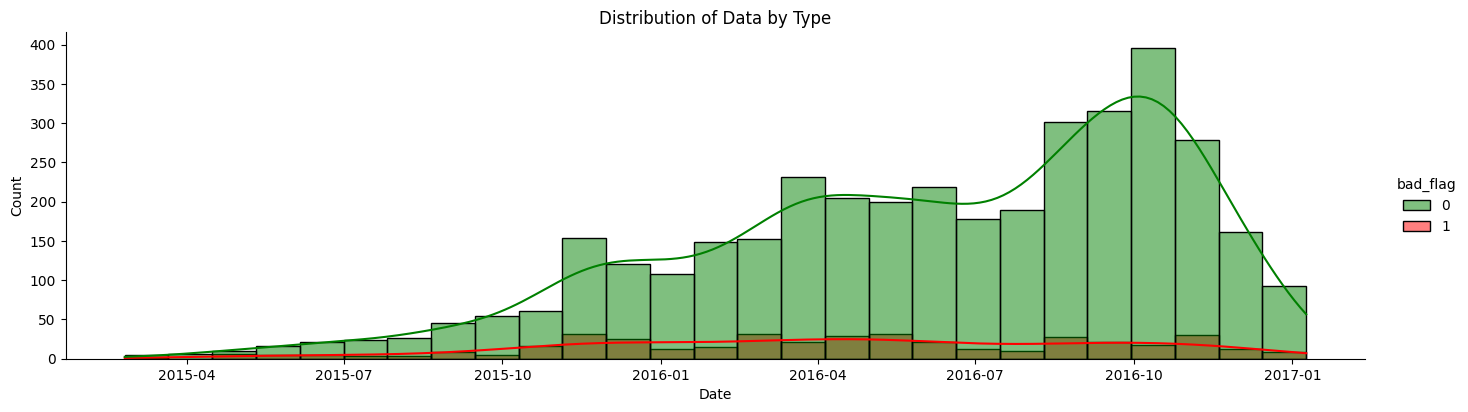

In [335]:
# visually inspecting distribution of time by transaction type
sns.displot(data=df, 
            x='rep_loan_date', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of Data by Type').set(xlabel='Date');



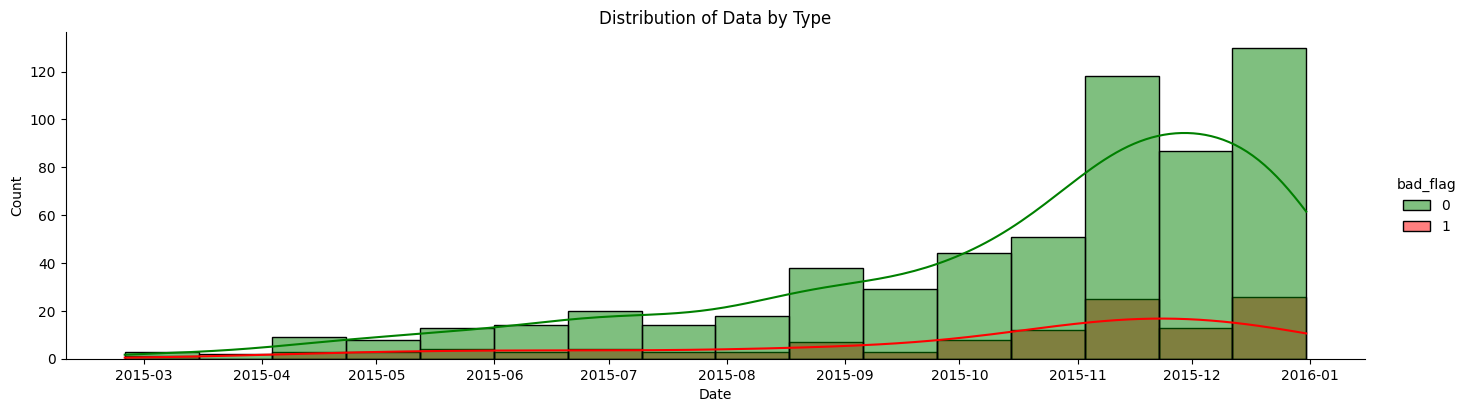

In [336]:
# Filter the DataFrame to only include rows with 'rep_loan_date' in year 2016
df_2015 = df[df['rep_loan_date'].dt.year == 2015]

# Create a displot with hue='bad_flag' for the filtered data
g = sns.displot(data=df_2015, x='rep_loan_date', hue='bad_flag', palette=['green', 'red'],
                kde=True, fill=True, height=4, aspect=3.5)

# Set title and x-axis label
g.set(title='Distribution of Data by Type', xlabel='Date')

# Show the plot
plt.show()

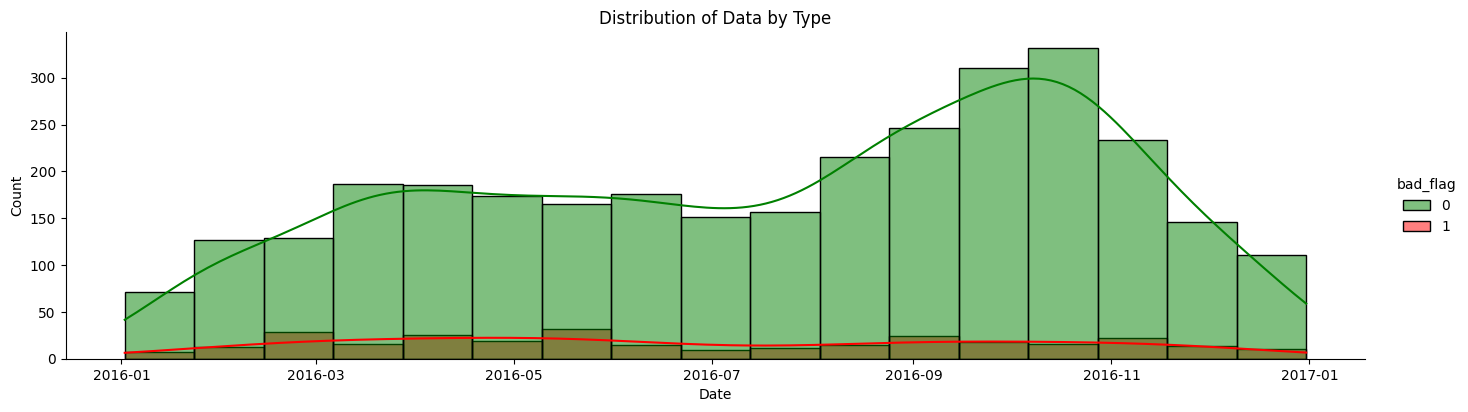

In [337]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame to only include rows with 'rep_loan_date' in year 2016
df_2016 = df[df['rep_loan_date'].dt.year == 2016]

# Create a displot with hue='bad_flag' for the filtered data
g = sns.displot(data=df_2016, x='rep_loan_date', hue='bad_flag', palette=['green', 'red'],
                kde=True, fill=True, height=4, aspect=3.5)

# Set title and x-axis label
g.set(title='Distribution of Data by Type', xlabel='Date')

# Show the plot
plt.show()


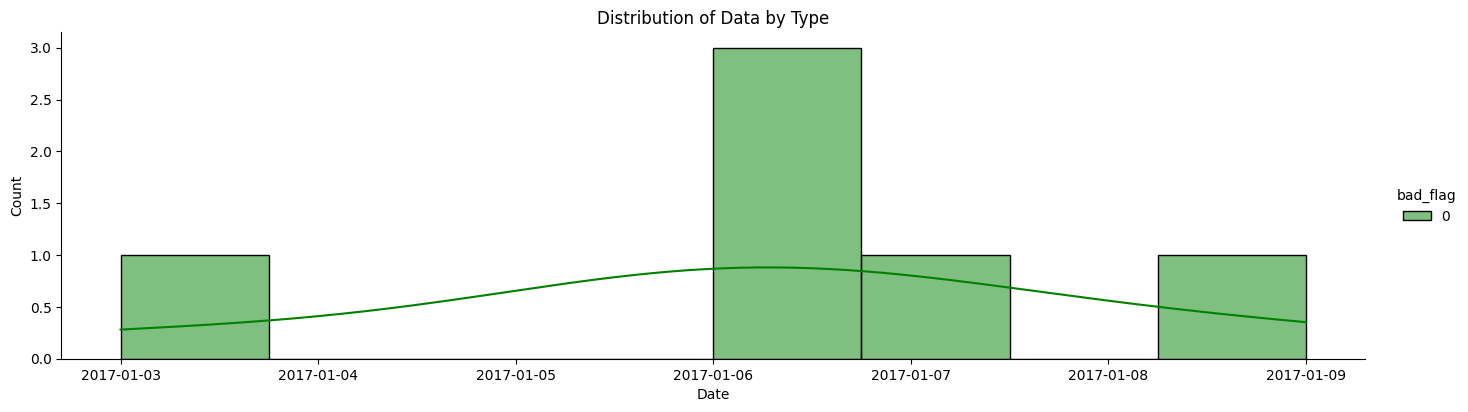

In [338]:
# Filter the DataFrame to only include rows with 'rep_loan_date' in year 2016
df_2017 = df[df['rep_loan_date'].dt.year == 2017]

# Create a displot with hue='bad_flag' for the filtered data
g = sns.displot(data=df_2017, x='rep_loan_date', hue='bad_flag', palette=['green', 'red'],
                kde=True, fill=True, height=4, aspect=3.5)

# Set title and x-axis label
g.set(title='Distribution of Data by Type', xlabel='Date')

# Show the plot
plt.show()

In [339]:
df_2017[df_2017['bad_flag'] == 0]

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,age,gender,bad_flag,rep_loan_date_year
392,879632,2017-01-03,2016-02-27,0.0,0.0,0.0,0,2.0,region_4,14,...,0,3,0,0,6.0,632.952178,32.0,False,0,2017
2265,882029,2017-01-06,2016-10-26,0.0,0.0,0.0,0,0.0,region_0,6,...,1,0,0,0,2.0,597.323225,27.0,False,0,2017
2565,881955,2017-01-06,2016-09-23,0.0,0.0,0.0,0,0.0,region_3,6,...,4,0,0,0,3.0,619.650810,29.0,False,0,2017
2739,882429,2017-01-07,2015-08-23,0.0,0.0,0.0,0,3.0,region_6,14,...,15,0,0,0,15.0,634.387608,44.0,False,0,2017
3371,881476,2017-01-06,2016-10-17,0.0,0.0,0.0,0,0.0,region_6,6,...,3,0,0,0,2.0,619.655855,32.0,False,0,2017
3377,884377,2017-01-09,2016-10-26,1.0,1.0,0.0,2016-12-02 00:00:00,0.0,region_4,38,...,2,0,0,0,2.0,640.928198,54.0,False,0,2017


In [340]:
df_2017[df_2017['bad_flag'] == 1]

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,age,gender,bad_flag,rep_loan_date_year


In [341]:
# Filter the DataFrame to exclude rows with 'rep_loan_date' in year 2017
df = df[df['rep_loan_date'].dt.year != 2017]

In [342]:
# Find the most recent date
most_recent_date = df['rep_loan_date'].max()

# Print the results
print('Most recent date:', most_recent_date)

Most recent date: 2016-12-31 00:00:00


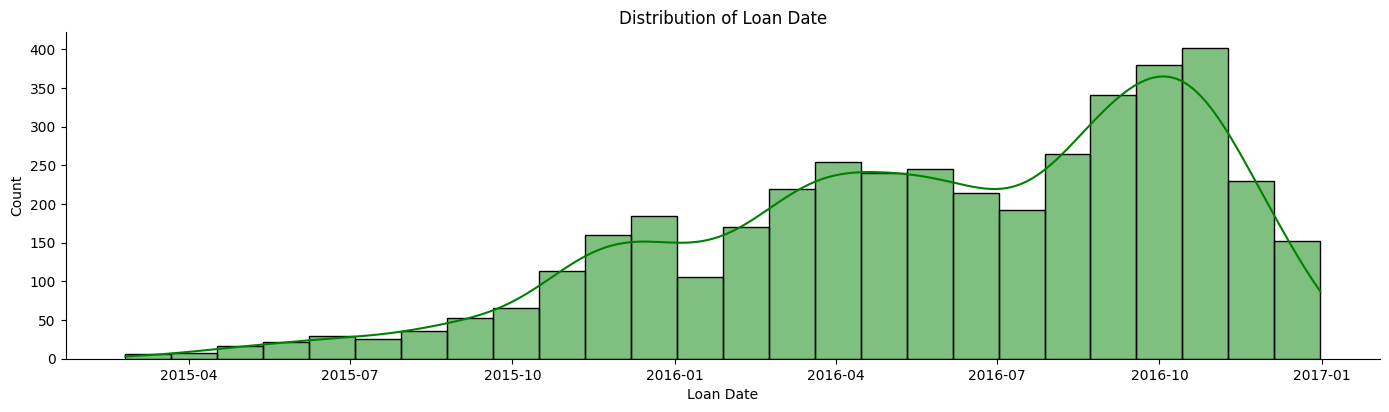

In [343]:
# Visually inspecting count distribution of feature
sns.displot(df.rep_loan_date, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of Loan Date').set(xlabel='Loan Date');

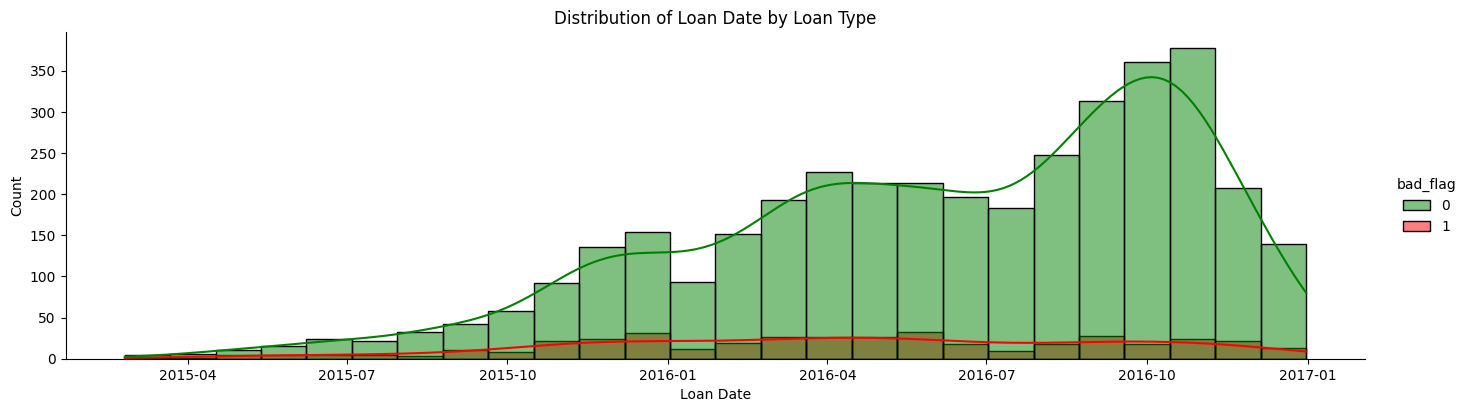

In [344]:
# Visually inspecting count distribution of feature by loan type
sns.displot(data=df, 
            x='rep_loan_date', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of Loan Date by Loan Type').set(xlabel='Loan Date');


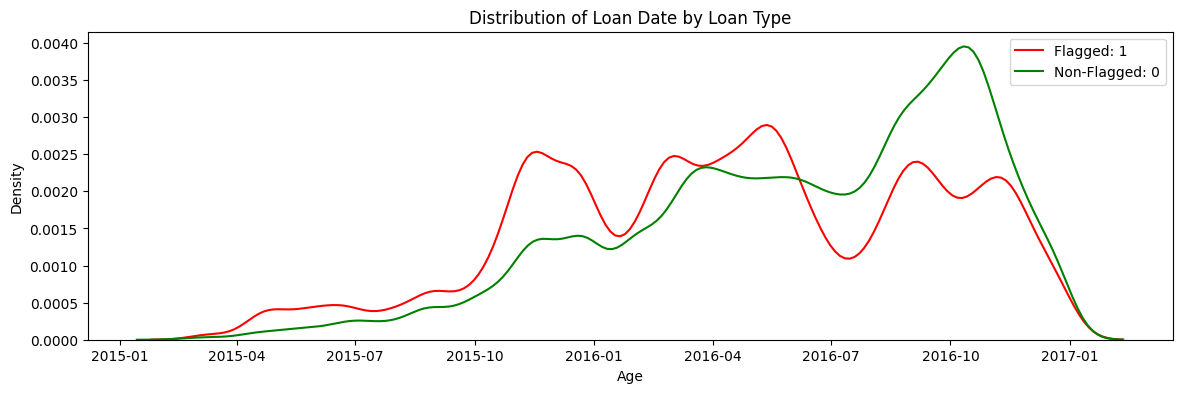

In [345]:
# Visually inspect density distribution of feature by loan type

data_plot = df.copy()
# specify column to use
column = 'rep_loan_date'
# create plot
plt.figure(figsize=(14, 4))
sns.kdeplot(data_plot[column][data_plot.bad_flag == 1], shade=False, label='Flagged: 1', color='red', 
            # adjusting to smaller bandwith to compensate for density scaling
            bw_method=0.1)
sns.kdeplot(data_plot[column][data_plot.bad_flag == 0], shade=False, label='Non-Flagged: 0', color='green', 
            bw_method=0.1)
plt.xlabel('Age')
plt.title('Distribution of Loan Date by Loan Type')
plt.legend()

plt.show();

Count of 5-day Delinquency

In [346]:
# inspecting values
df.dpd_5_cnt.value_counts(dropna=False)

0.0    3457
1.0     481
2.0     114
3.0      47
4.0      14
5.0       7
6.0       4
7.0       1
Name: dpd_5_cnt, dtype: int64

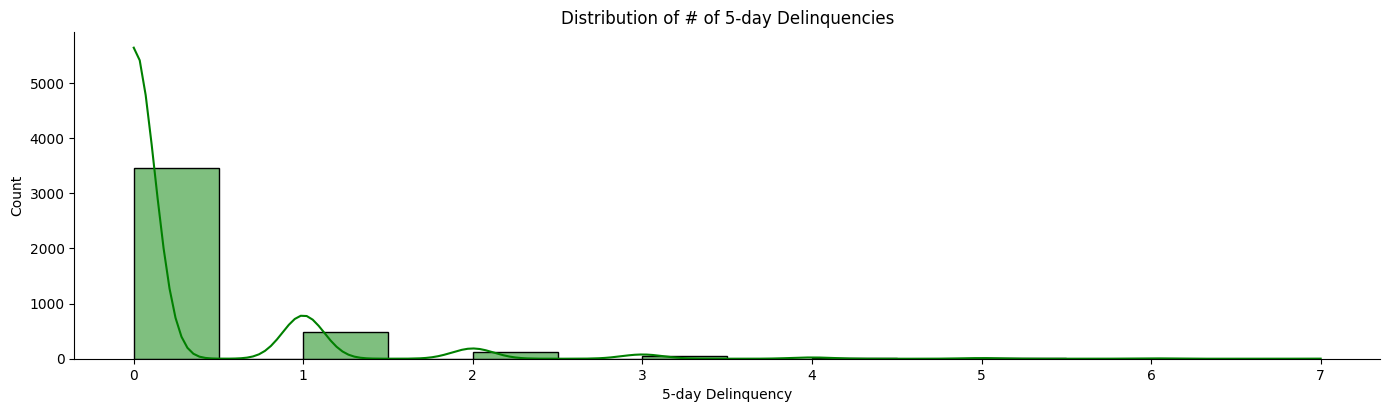

In [347]:
# Visually inspecting count distribution of feature
sns.displot(df.dpd_5_cnt, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of # of 5-day Delinquencies').set(xlabel='5-day Delinquency');

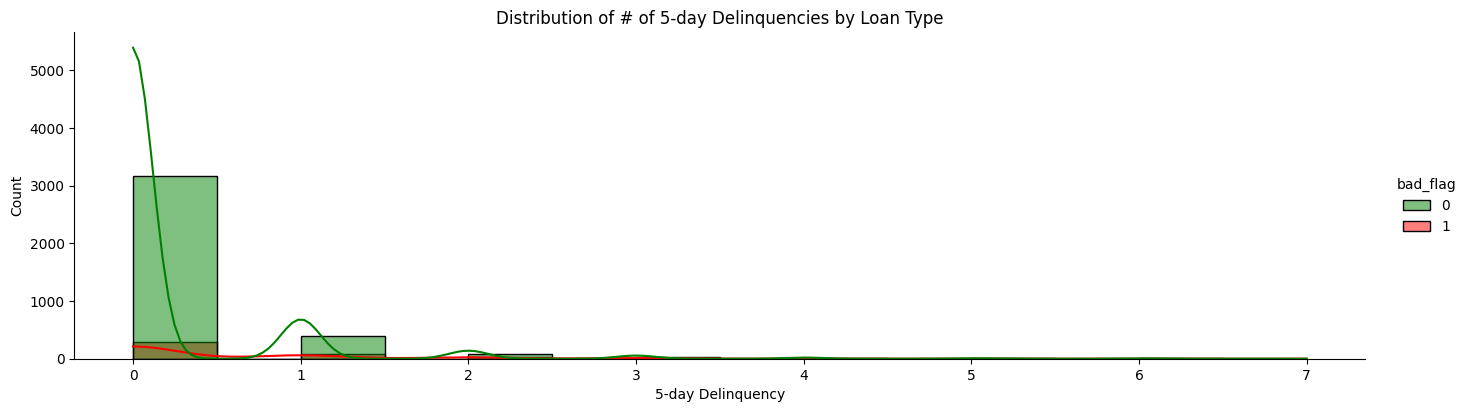

In [348]:
# Visually inspecting count distribution of feature by loan type
sns.displot(data=df, 
            x='dpd_5_cnt', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of # of 5-day Delinquencies by Loan Type').set(xlabel='5-day Delinquency');

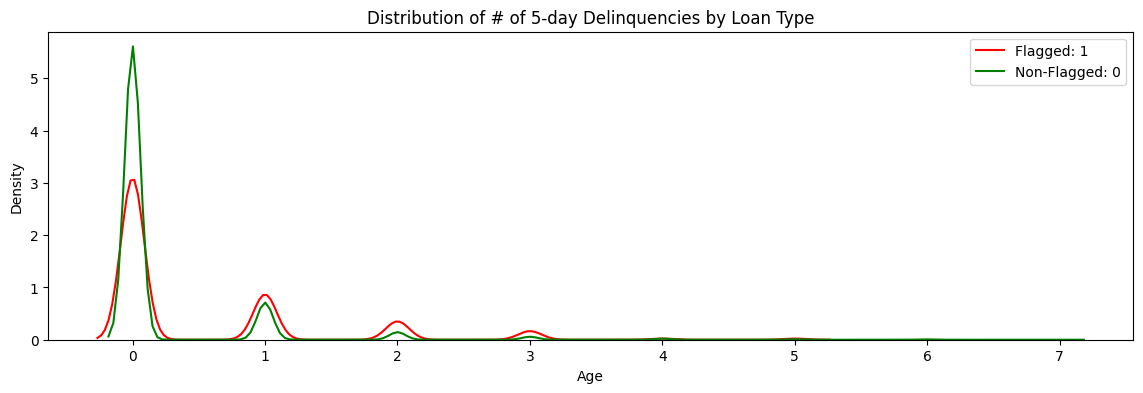

In [349]:
# Visually inspect density distribution of feature by loan type

data_plot = df.copy()
# Specify column to use
column = 'dpd_5_cnt'
# Create plot
plt.figure(figsize=(14, 4))
sns.kdeplot(data_plot[column][data_plot.bad_flag == 1], shade=False, label='Flagged: 1', color='red', 
            # Adjusting to smaller bandwith to compensate for density scaling
            bw_method=0.1)
sns.kdeplot(data_plot[column][data_plot.bad_flag == 0], shade=False, label='Non-Flagged: 0', color='green', 
            bw_method=0.1)
plt.xlabel('Age')
plt.title('Distribution of # of 5-day Delinquencies by Loan Type')
plt.legend()

plt.show();

Count of 15-day Delinquency

In [350]:
# Inspecting values
df.dpd_15_cnt.value_counts(dropna=False)

0.0    3734
1.0     311
2.0      66
3.0       9
4.0       3
5.0       2
Name: dpd_15_cnt, dtype: int64

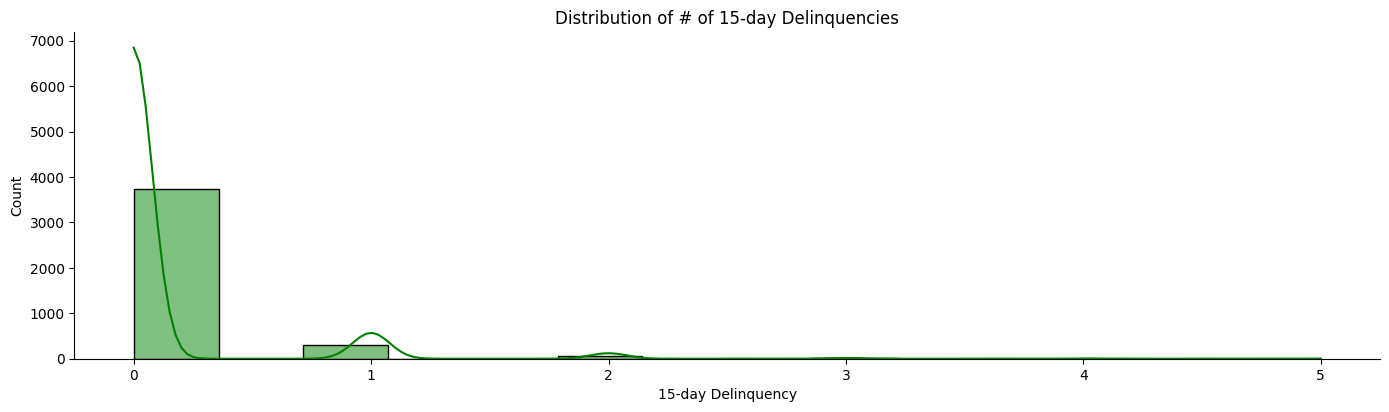

In [351]:
# Visually inspecting count distribution of feature
sns.displot(df.dpd_15_cnt, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of # of 15-day Delinquencies').set(xlabel='15-day Delinquency');

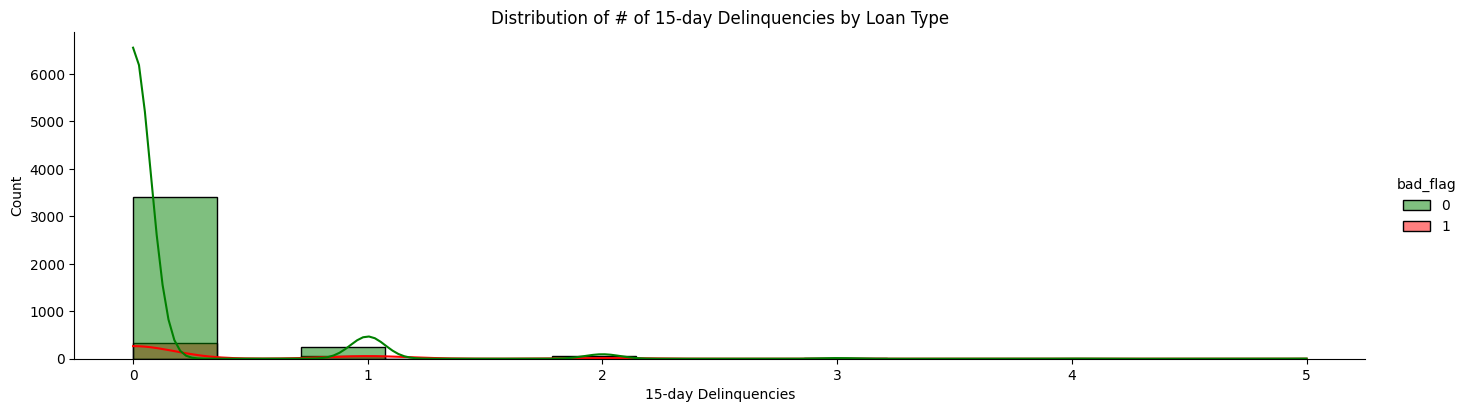

In [352]:
# Visually inspecting count distribution of feature by loan type
sns.displot(data=df, 
            x='dpd_15_cnt', 
            hue='bad_flag', 
            # Specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of # of 15-day Delinquencies by Loan Type').set(xlabel='15-day Delinquencies');

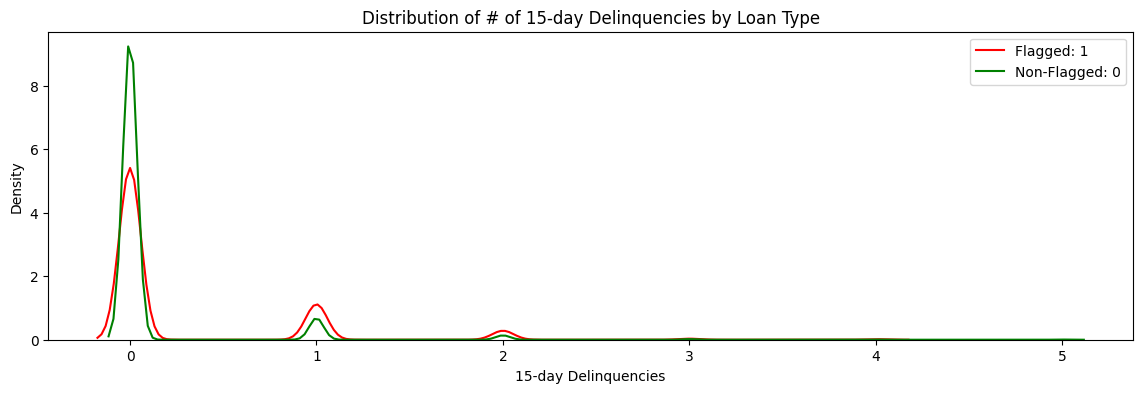

In [353]:
# Visually inspect density distribution of feature by loan type
data_plot = df.copy()
# Specify column to use
column = 'dpd_15_cnt'
# Create plot
plt.figure(figsize=(14, 4))
sns.kdeplot(data_plot[column][data_plot.bad_flag == 1], shade=False, label='Flagged: 1', color='red', 
            # Adjusting to smaller bandwidth to compensate for density scaling
            bw_method=0.1)
sns.kdeplot(data_plot[column][data_plot.bad_flag == 0], shade=False, label='Non-Flagged: 0', color='green', 
            bw_method=0.1)
plt.xlabel('15-day Delinquencies')
plt.title('Distribution of # of 15-day Delinquencies by Loan Type')
plt.legend()

plt.show();

Count of 30-day Delinquency

In [354]:
# Inspecting values
df.dpd_30_cnt.value_counts(dropna=False)

0.0    3953
1.0     157
2.0      14
3.0       1
Name: dpd_30_cnt, dtype: int64

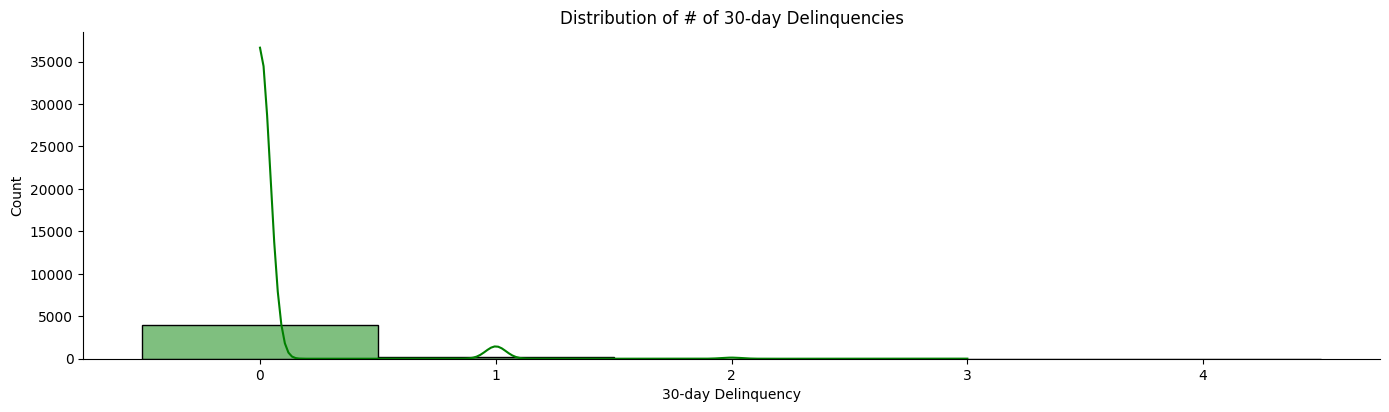

In [355]:
# Specify the bin edges to match the values of dpd_30_cnt column
bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]

# Visually inspecting count distribution of feature
sns.displot(df.dpd_30_cnt, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green',
            bins=bins).set(title='Distribution of # of 30-day Delinquencies').set(xlabel='30-day Delinquency');

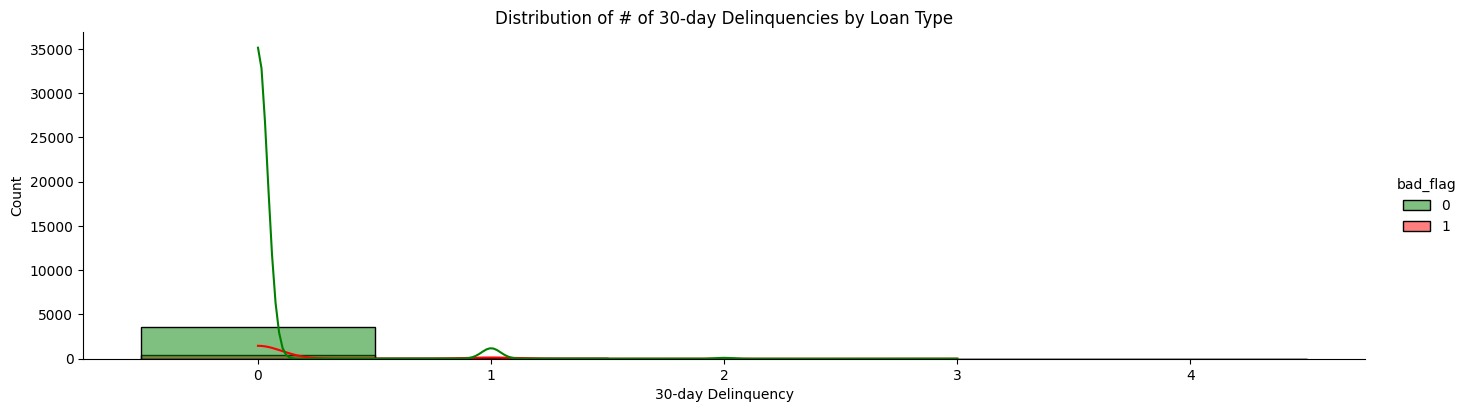

In [356]:
# Visually inspecting count distribution of feature by loan type
sns.displot(data=df, 
            x='dpd_30_cnt', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5,
            bins=bins).set(title='Distribution of # of 30-day Delinquencies by Loan Type').set(xlabel='30-day Delinquency');

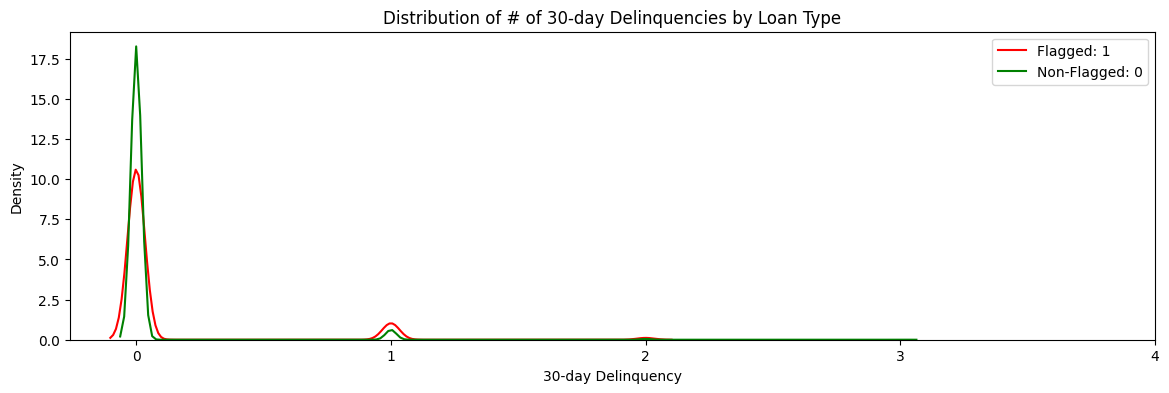

In [357]:
# Visually inspect density distribution of feature by loan type
data_plot = df.copy()
# Specify column to use
column = 'dpd_30_cnt'
# Create plot
plt.figure(figsize=(14, 4))
sns.kdeplot(data_plot[column][data_plot.bad_flag == 1], shade=False, label='Flagged: 1', color='red', 
            # Adjusting to smaller bandwidth to compensate for density scaling
            bw_method=0.1)
sns.kdeplot(data_plot[column][data_plot.bad_flag == 0], shade=False, label='Non-Flagged: 0', color='green', 
            bw_method=0.1)
plt.xlabel('30-day Delinquency')
plt.title('Distribution of # of 30-day Delinquencies by Loan Type')
# Set x-ticks at discrete values
plt.xticks([0, 1, 2, 3, 4])
plt.legend()

plt.show();

First overdue date

In [358]:
# Inspecting values
df.first_overdue_date.value_counts(dropna=False)

0                      3453
2016-01-15 00:00:00      63
2016-04-30 00:00:00      25
2016-05-30 00:00:00      21
2016-01-30 00:00:00      20
                       ... 
2015-06-10 00:00:00       1
2015-08-10 00:00:00       1
2016-12-02 00:00:00       1
2016-10-14 00:00:00       1
2016-06-14 00:00:00       1
Name: first_overdue_date, Length: 78, dtype: int64

In [359]:
# Convert 'first_overdue_date' column to datetime object with errors='coerce'
df['first_overdue_date'] = pd.to_datetime(df['first_overdue_date'], errors='coerce')

# Extract date part only
df['first_overdue_date'] = df['first_overdue_date'].dt.date

# Verify the data type of the 'first_overdue_date' column
print(df['first_overdue_date'].dtype)

object


In [360]:
# Inspecting values
df.first_overdue_date.value_counts(dropna=False)

NaT           3453
2016-01-15      63
2016-04-30      25
2016-05-30      21
2016-01-30      20
              ... 
2015-06-10       1
2015-08-10       1
2016-12-02       1
2016-10-14       1
2016-06-14       1
Name: first_overdue_date, Length: 78, dtype: int64

In [361]:
# Calculates the number of unique values to compare with total values
print(len(df.first_overdue_date.unique()))
len(df.first_overdue_date)

78


4125

In [362]:
df['first_overdue_date'] = df['first_overdue_date'].fillna(pd.Timestamp('1900-01-01'))  # Fill missing values with a default value

In [363]:
# Convert 'first_overdue_date' column to datetime object with errors='coerce'
df['first_overdue_date'] = pd.to_datetime(df['first_overdue_date'], errors='coerce')

# Extract date part only
df['first_overdue_date'] = df['first_overdue_date'].dt.date

# Verify the data type of the 'first_overdue_date' column
print(df['first_overdue_date'].dtype)

object


In [364]:
# Find the oldest date
oldest_date = df['first_overdue_date'].min()

# Find the most recent date
most_recent_date = df['first_overdue_date'].max()

# Print the results
print('Oldest date:', oldest_date)
print('Most recent date:', most_recent_date)

Oldest date: 1900-01-01
Most recent date: 2016-12-02


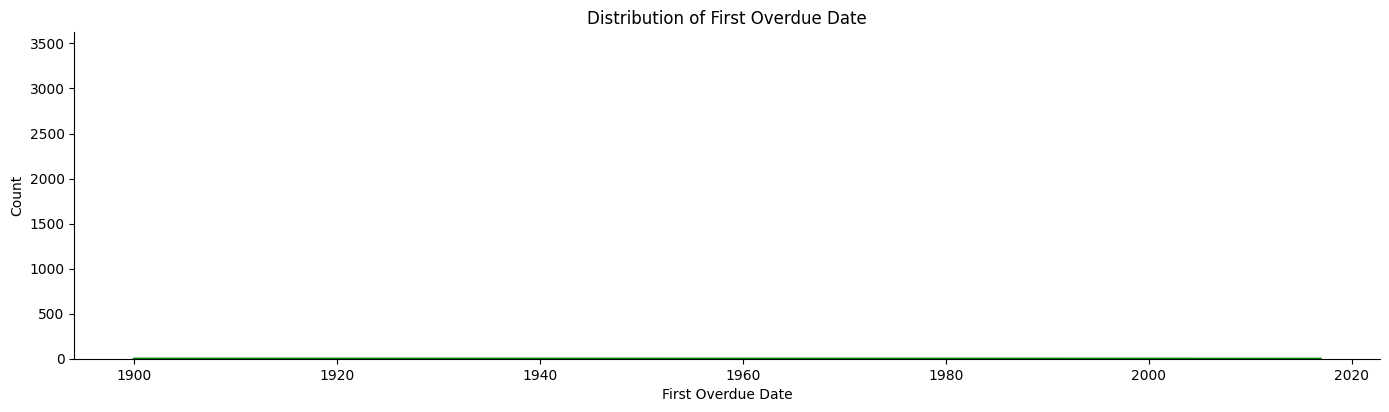

In [365]:
# Visually inspecting count distribution of feature
sns.displot(df.first_overdue_date, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of First Overdue Date').set(xlabel='First Overdue Date');

In [366]:
df.drop(columns='first_overdue_date', inplace=True)

Closed Loans

In [367]:
# inspecting values
df.close_loans_cnt.value_counts(dropna=False)

0.0     1665
1.0     1353
2.0      584
3.0      238
4.0      122
5.0       64
6.0       33
7.0       23
8.0       12
9.0        9
10.0       5
11.0       4
14.0       2
17.0       2
13.0       2
18.0       2
16.0       1
12.0       1
15.0       1
31.0       1
19.0       1
Name: close_loans_cnt, dtype: int64

In [368]:
data_flagged.close_loans_cnt.value_counts(dropna=False)

0.0     245
1.0      98
2.0      31
3.0      22
5.0       5
4.0       4
7.0       2
6.0       2
11.0      1
15.0      1
18.0      1
Name: close_loans_cnt, dtype: int64

In [369]:
data_non_flagged.close_loans_cnt.value_counts(dropna=False)

0.0     1424
1.0     1255
2.0      554
3.0      217
4.0      118
5.0       59
6.0       31
7.0       21
8.0       12
9.0        9
10.0       5
11.0       3
14.0       2
17.0       2
13.0       2
16.0       1
12.0       1
18.0       1
31.0       1
19.0       1
Name: close_loans_cnt, dtype: int64

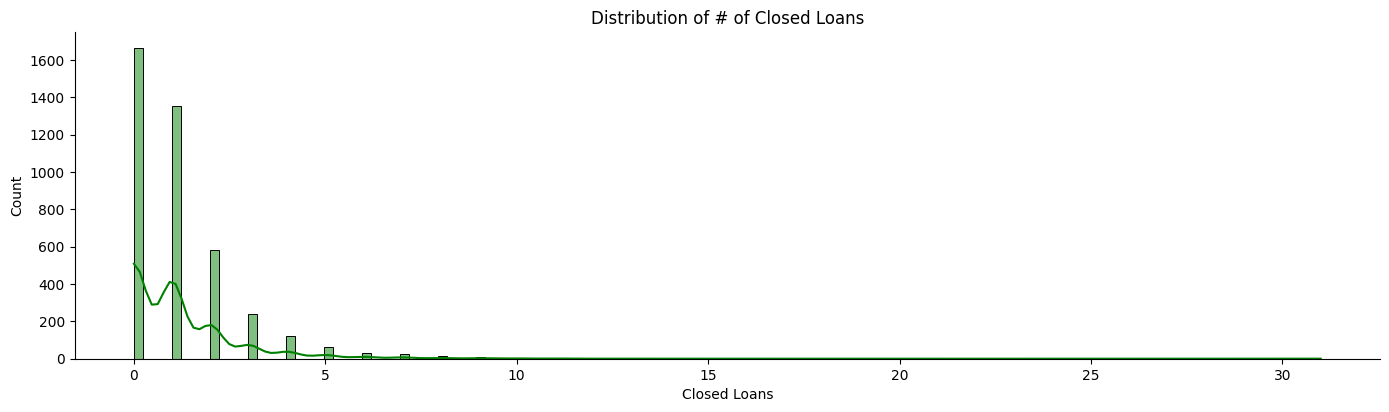

In [370]:
# Visually inspecting count distribution of feature
sns.displot(df.close_loans_cnt, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of # of Closed Loans').set(xlabel='Closed Loans');

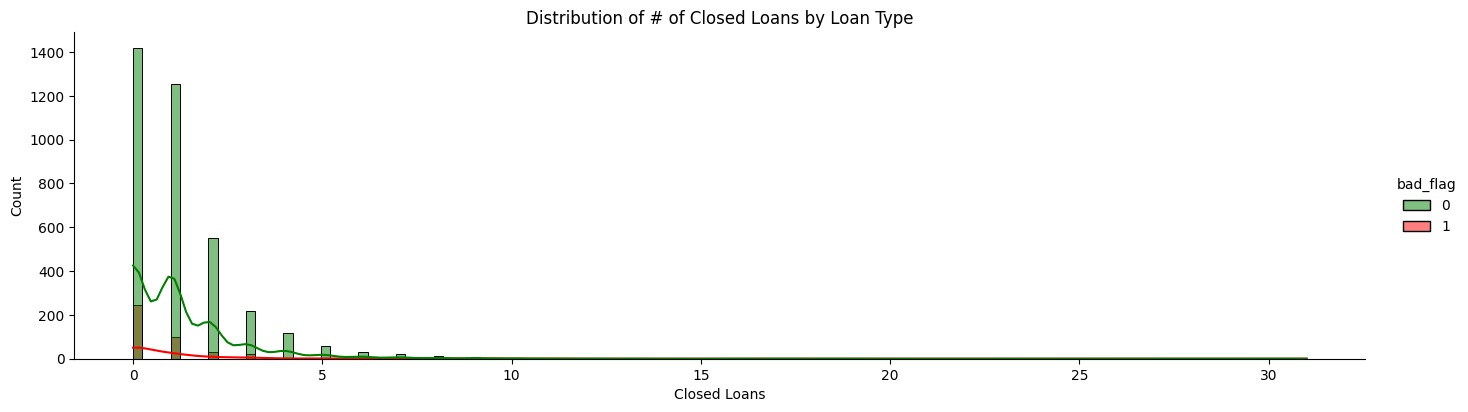

In [371]:
# Visually inspecting count distribution of feature by loan type
sns.displot(data=df, 
            x='close_loans_cnt', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of # of Closed Loans by Loan Type').set(xlabel='Closed Loans');


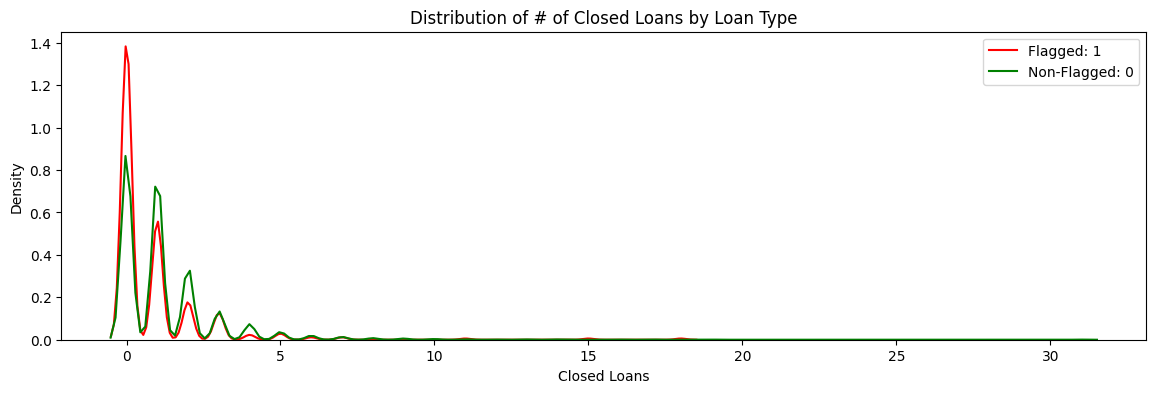

In [372]:
# Visually inspect density distribution of feature by loan type
data_plot = df.copy()
# Specify column to use
column = 'close_loans_cnt'
# Create plot
plt.figure(figsize=(14, 4))
sns.kdeplot(data_plot[column][data_plot.bad_flag == 1], shade=False, label='Flagged: 1', color='red', 
            # Adjusting to smaller bandwith to compensate for density scaling
            bw_method=0.1)
sns.kdeplot(data_plot[column][data_plot.bad_flag == 0], shade=False, label='Non-Flagged: 0', color='green', 
            bw_method=0.1)
plt.xlabel('Closed Loans')
plt.title('Distribution of # of Closed Loans by Loan Type')
plt.legend()

plt.show();

Region

In [373]:
# inspecting values
df.federal_district_nm.value_counts(dropna=False)

region_3    1586
region_6     624
region_2     551
region_4     497
region_1     299
region_0     284
region_5     211
region_7      73
Name: federal_district_nm, dtype: int64

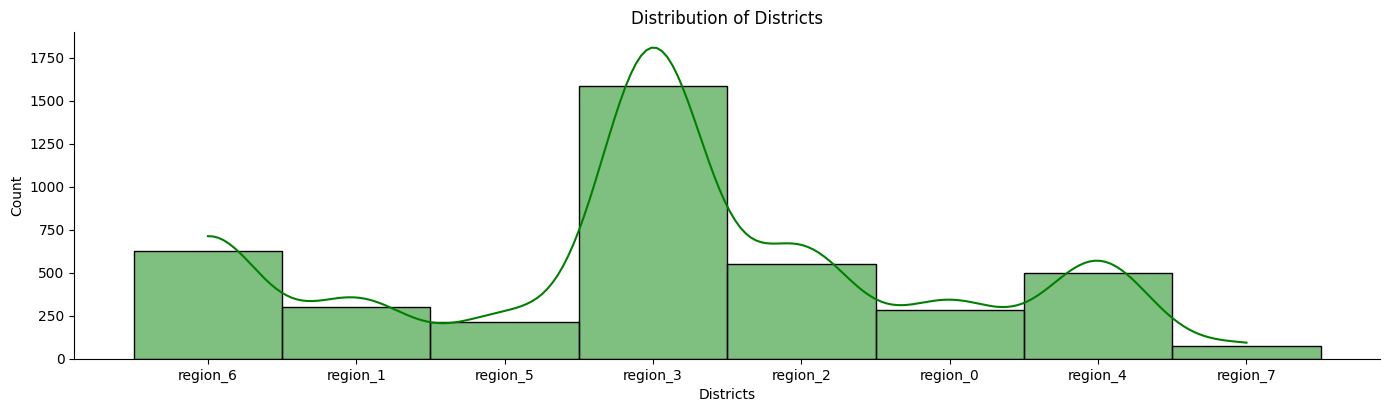

In [374]:
# Visually inspecting count distribution of feature
sns.displot(df.federal_district_nm, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of Districts').set(xlabel='Districts');

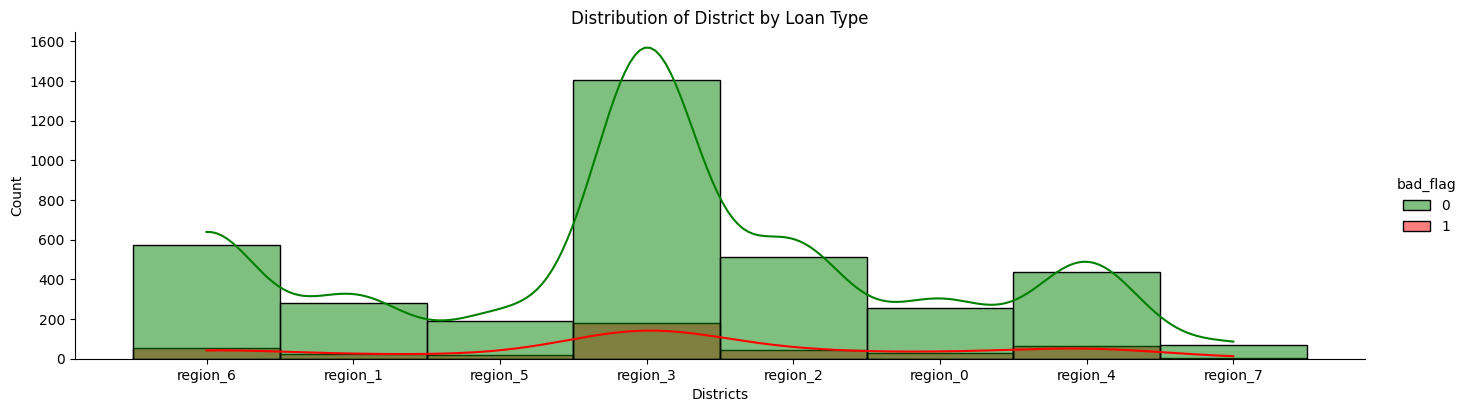

In [375]:
# Visually inspecting count distribution of feature by loan type
sns.displot(data=df, 
            x='federal_district_nm', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of District by Loan Type').set(xlabel='Districts');


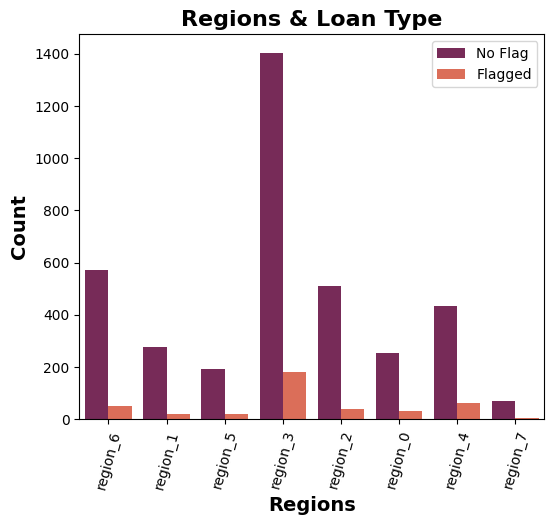

In [380]:
# plotting Region by loan type 
plt.figure(figsize=(6,5))
sns.countplot(x='federal_district_nm', 
              hue='bad_flag', 
              data=df, 
              palette='rocket')
plt.ylabel('Count', weight='bold', size=14)
plt.xlabel('Regions', weight='bold', size=14)
plt.title('Regions & Loan Type', weight='bold', size=16)
plt.legend(['No Flag','Flagged'])
plt.xticks(rotation=75);



In [ ]:
We will oone hot encode the 

#### Trader Key

In [ ]:
# Inspecting values
df.TraderKey.value_counts(dropna=False)

6     2198
12     749
26     312
22     191
38     166
7      127
25      97
14      88
17      84
16      43
44      22
42      12
78       7
48       5
21       5
1        5
46       4
57       2
9        2
76       2
43       2
60       2
Name: TraderKey, dtype: int64

Payment Type 0

In [ ]:
# Inspecting values
df.payment_type_0.value_counts(dropna=False)

0     4097
1       13
2        6
3        3
5        2
4        1
15       1
6        1
8        1
Name: payment_type_0, dtype: int64

Payment Type 1

In [ ]:
# Inspecting values
df.payment_type_1.value_counts(dropna=False)

0     3606
1      128
2       84
3       84
4       42
5       38
6       28
7       25
8       15
9       14
10      10
12       9
11       9
18       6
15       4
17       4
14       4
13       3
20       2
16       2
21       1
28       1
31       1
23       1
36       1
24       1
81       1
22       1
Name: payment_type_1, dtype: int64

#### Payment Type 2

In [ ]:
# Inspecting values
df.payment_type_2.value_counts(dropna=False)

0     872
3     576
1     530
2     472
6     335
4     305
5     274
7     150
8     134
9     122
10     99
12     57
11     55
13     37
14     32
15     18
16     17
18     12
17      9
20      6
19      6
24      2
21      2
33      1
29      1
25      1
Name: payment_type_2, dtype: int64

#### Payment Type 3

In [ ]:
# Inspecting values
df.payment_type_3.value_counts(dropna=False)

0     3323
1      217
2      135
3      129
4       79
6       67
5       53
8       24
7       24
9       16
10      16
11      15
12       8
15       5
16       3
13       2
17       2
19       2
20       1
21       1
23       1
30       1
14       1
Name: payment_type_3, dtype: int64

#### Payment Type 4

In [ ]:
# Inspecting values
df.payment_type_4.value_counts(dropna=False)

0    4086
1      24
2       5
3       4
5       3
4       2
7       1
Name: payment_type_4, dtype: int64

Payment Type 5

In [ ]:
# Inspecting values
df.payment_type_5.value_counts(dropna=False)

0    4125
Name: payment_type_5, dtype: int64

In [ ]:
# Drop column
df.drop(columns='payment_type_5', inplace=True)

#### Past Bills

In [ ]:
# Inspecting values
df.past_billings_cnt.value_counts(dropna=False)

3.0     805
6.0     520
1.0     496
2.0     486
5.0     335
4.0     287
0.0     233
7.0     205
8.0     176
9.0     152
10.0    122
11.0     72
12.0     69
13.0     43
14.0     40
16.0     28
15.0     21
17.0     19
18.0      9
19.0      3
20.0      2
21.0      2
Name: past_billings_cnt, dtype: int64

#### Score

In [ ]:
# Inspecting values
df.score_1.value_counts(dropna=False)

0.000000      645
601.979112     78
612.219738     78
632.952178     71
634.387608     67
             ... 
670.797025      1
460.841340      1
491.705937      1
581.846003      1
644.849810      1
Name: score_1, Length: 1267, dtype: int64

#### Age

In [ ]:
# Inspecting values
df.age.value_counts(dropna=False)

28.0    189
27.0    176
31.0    176
30.0    167
26.0    164
32.0    159
24.0    158
29.0    153
33.0    151
35.0    145
25.0    141
34.0    139
23.0    131
36.0    125
21.0    121
39.0    111
37.0    109
38.0    102
41.0    101
22.0    101
40.0     98
20.0     89
18.0     81
43.0     79
42.0     77
44.0     65
19.0     65
47.0     59
46.0     59
45.0     57
51.0     53
48.0     52
54.0     44
53.0     43
49.0     40
56.0     39
52.0     38
55.0     36
59.0     34
58.0     33
57.0     32
50.0     32
60.0     22
63.0     22
61.0     18
62.0     16
64.0     14
65.0      6
67.0      1
74.0      1
70.0      1
Name: age, dtype: int64

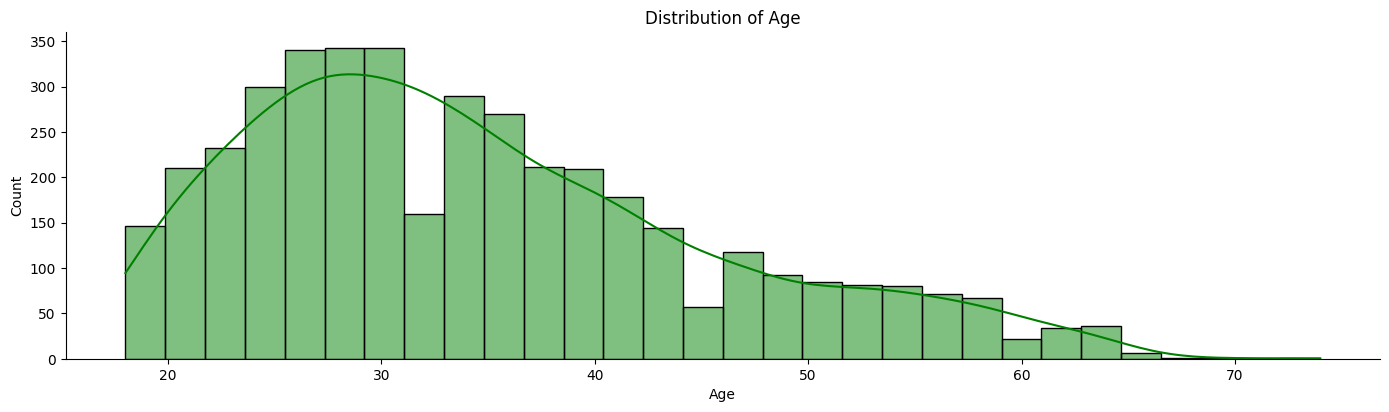

In [90]:
# visually inspecting time
sns.displot(df.age, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of Age').set(xlabel='Age');

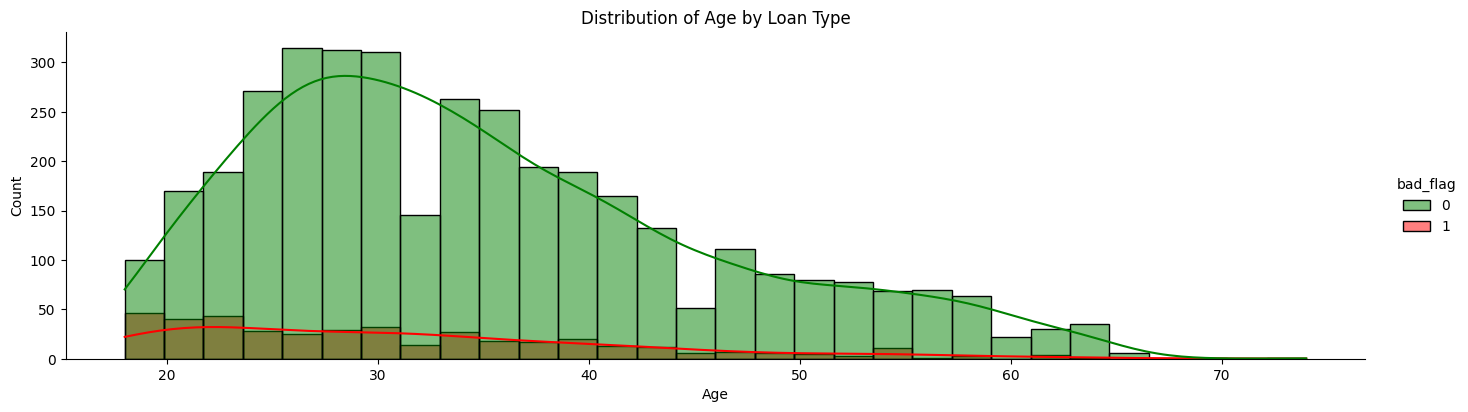

In [91]:
# visually inspecting distribution of time by transaction type
sns.displot(data=df, 
            x='age', 
            hue='bad_flag', 
            # specifiying colors for each class
            palette=['green', 'red'],
            kde=True, 
            fill=True, 
            height=4, 
            aspect=3.5).set(title='Distribution of Age by Loan Type').set(xlabel='Age');

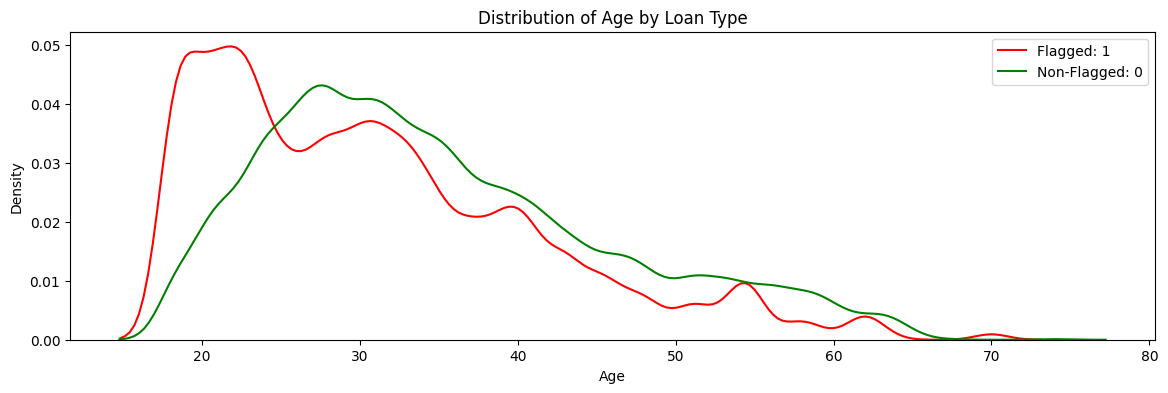

In [92]:
# visually inspect classes by density and hour
data_plot = df.copy()
# specify column to use
column = 'age'
# create plot
plt.figure(figsize=(14, 4))
sns.kdeplot(data_plot[column][data_plot.bad_flag == 1], shade=False, label='Flagged: 1', color='red', 
            # adjusting to smaller bandwith to compensate for density scaling
            bw_method=0.1)
sns.kdeplot(data_plot[column][data_plot.bad_flag == 0], shade=False, label='Non-Flagged: 0', color='green', 
            bw_method=0.1)
plt.xlabel('Age')
plt.title('Distribution of Age by Loan Type')
plt.legend()

plt.show();

#### Gender

In [ ]:
# Inspecting values
df.gender.value_counts(dropna=False)

False    3543
True      582
Name: gender, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit and transform the 'gender' column
df['gender_encoded'] = le.fit_transform(df['gender'])

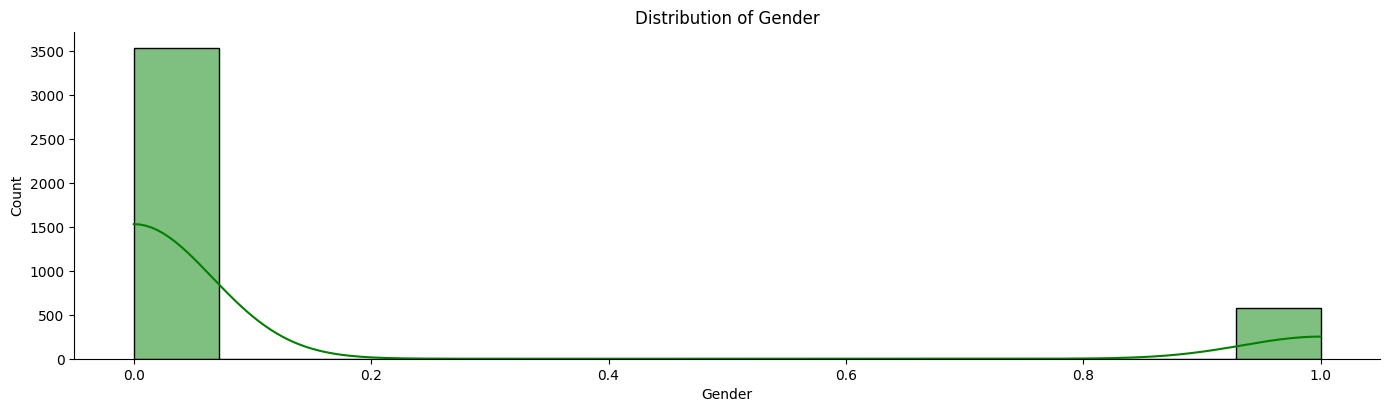

In [89]:
# visually inspecting time
sns.displot(df.gender_encoded, 
            height=4, 
            aspect=3.5, 
            kde=True,
            color='green').set(title='Distribution of Gender').set(xlabel='Gender');

In [ ]:
from scipy.stats import skew

# Visually inspect 28 other features 
data_plot = df.copy()
# Exclude datetime objects
data_plot = data_plot.select_dtypes(exclude='datetime')
# Convert column to numeric data type
data_plot[index] = pd.to_numeric(data_plot[index], errors='coerce')
# Specify columns to use
columns = data_plot.columns

#
plt.figure(figsize=(12, 30*4))
grids = gridspec.GridSpec(30, 1)
for grid, index in enumerate(data_plot[columns]):
    ax = plt.subplot(grids[grid])
    sns.kdeplot(data_plot[data_plot.bad_flag == 1][index], shade=True, ax=ax, label='Class 1')
    sns.kdeplot(data_plot[data_plot.bad_flag == 0][index], shade=True, ax=ax, label='Class 0')
    ax.set_xlabel("")
    ax.set_title(f"Distribution of Column: {index} (Skewness: {skew(df[index]):.2f})")
plt.show();

NameError: ignored

In [ ]:
from scipy.stats import skew

# Visually inspect 28 other features 
data_plot = df.copy()
# Exclude datetime objects
data_plot = data_plot.select_dtypes(exclude='datetime')
# Specify columns to use
columns = data_plot.columns

#
plt.figure(figsize=(12, 30*4))
grids = gridspec.GridSpec(30, 1)
for grid, index in enumerate(data_plot[columns]):
    ax = plt.subplot(grids[grid])
    sns.kdeplot(data_plot[index][data_plot.bad_flag == 1], shade=True, ax=ax, label='Class 1')
    sns.kdeplot(data_plot[index][data_plot.bad_flag == 0], shade=True, ax=ax, label='Class 0')
    ax.set_xlabel("")
    ax.set_title(f"Distribution of Column: {index} (Skewness: {skew(df[index]):.2f})")
plt.show();

In [ ]:

df['first_loan_year'] = pd.to_datetime(df['first_loan']).dt.year

In [ ]:
df['first_loan_year'].value_counts(dropna=False)

In [ ]:
df.info()